In [1]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd

In [2]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [3]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [4]:
def src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None
    new_features = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            portion_rest = (avg_number/new_chosen.shape[0]) - c_portion

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            
        for j in range(c_portion):
            num = int(new_chosen.shape[0])
            new_chosen = new_chosen[:num]

            chosen_embed = features[new_chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

            if chosen is None:
                chosen = new_chosen
                new_features = embed
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
                new_features = torch.cat((new_features, embed),0)
            
        num = int(new_chosen.shape[0]*portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:]
        distance = squareform(pdist(chosen_embed.detach()))
        np.fill_diagonal(distance,distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)
            
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed),0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(new_features)
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [5]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [6]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x


#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.sigmoid(torch.mm(combine, combine.transpose(-1,-2)))

        return adj_out

In [7]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [8]:
data=pd.read_csv("interactions_smote.csv")
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
Graphtype = nx.Graph()
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()
#node_features = np.loadtxt('node_features_smote.txt')
node_features= np.ones((adj.shape[0],1))
#labels = np.loadtxt('Multi-Labels.txt')
labels = np.loadtxt('Labels.txt')
#labels = np.loadtxt('syndromic-Labels.txt')

In [9]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 6000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [10]:
for i in range(4):
#for i in range(6):
#for i in range(7):
        print(i)
        print("-----------------------------------")
        idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
        #adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=3)
        adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)
        print("-----------------------------------")

0
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 813
-----------------------------------
1
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 1626
-----------------------------------
2
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 3252
-----------------------------------
3
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 6504
-----------------------------------


In [11]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 11403
1-th class sample number: 12504


In [12]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [13]:
encoder = GCN_En(nfeat=features.shape[1],
        nhid=128,
        nembed=128,
        dropout=0)
classifier = GCN_Classifier(nembed=128, 
        nhid=128, 
        nclass=labels.max().item() + 1, 
        dropout=0)
decoder = Decoder(nembed=128,
        dropout=0)


optimizer_en = optim.AdamW(encoder.parameters(),
                       lr=0.0005,weight_decay=5e-4,eps=1e-04)
optimizer_cls = optim.AdamW(classifier.parameters(),
                       lr=0.0005,weight_decay=5e-4,eps=1e-04)
optimizer_de = optim.AdamW(decoder.parameters(),
                       lr=0.0005,weight_decay=5e-4,eps=1e-04)


In [14]:
features.shape[1]

1

In [15]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [16]:
def train(epoch):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)
    output_log=torch.nn.functional.log_softmax(output)
    loss_train = F.cross_entropy(output_log[idx_train_new], labels_new[idx_train_new])
    
    acc_train = accuracy(output_log[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()
    loss_val = F.cross_entropy(output_log[idx_val], labels[idx_val])
    
    acc_val = accuracy(output_log[idx_val], labels[idx_val])

    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    output_log=torch.nn.functional.log_softmax(output)
    loss_test = F.cross_entropy(output_log[idx_test], labels[idx_test])
    
    acc_test = accuracy(output_log[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [17]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [18]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_83308\4161052455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_83308\4161052455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [19]:

t_total = time.time()
for epoch in range(5000):
    train(epoch)

    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_83308\343820884.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_log=torch.nn.functional.log_softmax(output)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_83308\343820884.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_log=torch.nn.functional.log_softmax(output)


Epoch: 00001 loss_train: 424.8289 loss_rec: 424.8289 acc_train: 0.4992 loss_val: 431.2959 acc_val: 0.5000 time: 0.6586s
Test set results: loss= 222.4456 accuracy= 0.4421
Epoch: 00002 loss_train: 195.9108 loss_rec: 195.9108 acc_train: 0.5000 loss_val: 194.4079 acc_val: 0.5000 time: 0.0278s
Epoch: 00003 loss_train: 166.6815 loss_rec: 166.6815 acc_train: 0.5000 loss_val: 165.3843 acc_val: 0.5000 time: 0.0273s
Epoch: 00004 loss_train: 77.5822 loss_rec: 77.5822 acc_train: 0.4936 loss_val: 78.7621 acc_val: 0.4967 time: 0.0278s
Epoch: 00005 loss_train: 60.2277 loss_rec: 60.2277 acc_train: 0.4899 loss_val: 61.1435 acc_val: 0.4942 time: 0.0258s
Epoch: 00006 loss_train: 107.9614 loss_rec: 107.9614 acc_train: 0.5000 loss_val: 107.0632 acc_val: 0.5000 time: 0.0268s
Epoch: 00007 loss_train: 110.2623 loss_rec: 110.2623 acc_train: 0.5000 loss_val: 109.3448 acc_val: 0.5000 time: 0.0258s
Epoch: 00008 loss_train: 3.0473 loss_rec: 3.0473 acc_train: 0.4808 loss_val: 3.0948 acc_val: 0.4871 time: 0.0308s
Ep

Test set results: loss= 116.5755 accuracy= 0.5539
Epoch: 00072 loss_train: 129.8073 loss_rec: 129.8073 acc_train: 0.4961 loss_val: 131.7806 acc_val: 0.4983 time: 0.0363s
Epoch: 00073 loss_train: 17.4773 loss_rec: 17.4773 acc_train: 0.4903 loss_val: 17.7423 acc_val: 0.4954 time: 0.0343s
Epoch: 00074 loss_train: 135.8453 loss_rec: 135.8453 acc_train: 0.4984 loss_val: 134.5553 acc_val: 0.4979 time: 0.0258s
Epoch: 00075 loss_train: 218.1856 loss_rec: 218.1856 acc_train: 0.4987 loss_val: 216.3256 acc_val: 0.4979 time: 0.0273s
Epoch: 00076 loss_train: 238.1050 loss_rec: 238.1050 acc_train: 0.4987 loss_val: 236.1039 acc_val: 0.4979 time: 0.0263s
Epoch: 00077 loss_train: 202.2255 loss_rec: 202.2255 acc_train: 0.4987 loss_val: 200.4708 acc_val: 0.4979 time: 0.0263s
Epoch: 00078 loss_train: 116.3788 loss_rec: 116.3788 acc_train: 0.4982 loss_val: 115.2184 acc_val: 0.4983 time: 0.0264s
Epoch: 00079 loss_train: 13.9177 loss_rec: 13.9177 acc_train: 0.4903 loss_val: 14.1290 acc_val: 0.4954 time: 0.02

Epoch: 00142 loss_train: 67.6706 loss_rec: 67.6706 acc_train: 0.5133 loss_val: 66.7619 acc_val: 0.5179 time: 0.0293s
Epoch: 00143 loss_train: 30.4877 loss_rec: 30.4877 acc_train: 0.4927 loss_val: 30.9488 acc_val: 0.4971 time: 0.0273s
Epoch: 00144 loss_train: 67.0686 loss_rec: 67.0686 acc_train: 0.4949 loss_val: 68.0860 acc_val: 0.4975 time: 0.0268s
Epoch: 00145 loss_train: 44.2490 loss_rec: 44.2490 acc_train: 0.4934 loss_val: 44.9193 acc_val: 0.4975 time: 0.0273s
Epoch: 00146 loss_train: 29.4633 loss_rec: 29.4633 acc_train: 0.5317 loss_val: 29.0983 acc_val: 0.5408 time: 0.0258s
Epoch: 00147 loss_train: 44.5730 loss_rec: 44.5730 acc_train: 0.5251 loss_val: 44.0034 acc_val: 0.5312 time: 0.0263s
Epoch: 00148 loss_train: 8.8253 loss_rec: 8.8253 acc_train: 0.5490 loss_val: 8.7124 acc_val: 0.5525 time: 0.0273s
Epoch: 00149 loss_train: 75.7439 loss_rec: 75.7439 acc_train: 0.4949 loss_val: 76.8933 acc_val: 0.4975 time: 0.0278s
Epoch: 00150 loss_train: 97.2046 loss_rec: 97.2046 acc_train: 0.496

Epoch: 00211 loss_train: 29.1615 loss_rec: 29.1615 acc_train: 0.4934 loss_val: 29.6017 acc_val: 0.4975 time: 0.0283s
Test set results: loss= 39.2164 accuracy= 0.4865
Epoch: 00212 loss_train: 34.5675 loss_rec: 34.5675 acc_train: 0.5368 loss_val: 34.1369 acc_val: 0.5429 time: 0.0273s
Epoch: 00213 loss_train: 43.4134 loss_rec: 43.4134 acc_train: 0.5306 loss_val: 42.8643 acc_val: 0.5392 time: 0.0268s
Epoch: 00214 loss_train: 3.9780 loss_rec: 3.9780 acc_train: 0.5552 loss_val: 3.9468 acc_val: 0.5600 time: 0.0273s
Epoch: 00215 loss_train: 81.7440 loss_rec: 81.7440 acc_train: 0.4961 loss_val: 82.9844 acc_val: 0.4983 time: 0.0308s
Epoch: 00216 loss_train: 105.6428 loss_rec: 105.6428 acc_train: 0.4961 loss_val: 107.2469 acc_val: 0.4983 time: 0.0402s
Epoch: 00217 loss_train: 73.3755 loss_rec: 73.3755 acc_train: 0.4956 loss_val: 74.4883 acc_val: 0.4975 time: 0.0387s
Epoch: 00218 loss_train: 8.3336 loss_rec: 8.3336 acc_train: 0.5498 loss_val: 8.2340 acc_val: 0.5554 time: 0.0372s
Epoch: 00219 loss_

Epoch: 00284 loss_train: 6.3012 loss_rec: 6.3012 acc_train: 0.5519 loss_val: 6.2401 acc_val: 0.5554 time: 0.0293s
Epoch: 00285 loss_train: 95.0902 loss_rec: 95.0902 acc_train: 0.4962 loss_val: 96.5334 acc_val: 0.4983 time: 0.0348s
Epoch: 00286 loss_train: 135.2846 loss_rec: 135.2846 acc_train: 0.4983 loss_val: 137.3400 acc_val: 0.4988 time: 0.0283s
Epoch: 00287 loss_train: 119.6977 loss_rec: 119.6977 acc_train: 0.4977 loss_val: 121.5154 acc_val: 0.4983 time: 0.0323s
Epoch: 00288 loss_train: 54.0770 loss_rec: 54.0770 acc_train: 0.4950 loss_val: 54.8958 acc_val: 0.4975 time: 0.0353s
Epoch: 00289 loss_train: 52.2926 loss_rec: 52.2926 acc_train: 0.5304 loss_val: 51.6297 acc_val: 0.5379 time: 0.0343s
Epoch: 00290 loss_train: 100.3651 loss_rec: 100.3651 acc_train: 0.5147 loss_val: 99.0107 acc_val: 0.5204 time: 0.0328s
Epoch: 00291 loss_train: 97.1737 loss_rec: 97.1737 acc_train: 0.5155 loss_val: 95.8716 acc_val: 0.5212 time: 0.0358s
Test set results: loss= 54.5495 accuracy= 0.4799
Epoch: 002

Epoch: 00358 loss_train: 58.6029 loss_rec: 58.6029 acc_train: 0.4952 loss_val: 59.4902 acc_val: 0.4983 time: 0.0288s
Epoch: 00359 loss_train: 13.6189 loss_rec: 13.6189 acc_train: 0.4932 loss_val: 13.8225 acc_val: 0.4988 time: 0.0258s
Epoch: 00360 loss_train: 70.9554 loss_rec: 70.9554 acc_train: 0.5275 loss_val: 70.0479 acc_val: 0.5333 time: 0.0258s
Epoch: 00361 loss_train: 103.2689 loss_rec: 103.2689 acc_train: 0.5195 loss_val: 101.9024 acc_val: 0.5258 time: 0.0273s
Test set results: loss= 99.6192 accuracy= 0.4692
Epoch: 00362 loss_train: 87.7463 loss_rec: 87.7463 acc_train: 0.5252 loss_val: 86.6131 acc_val: 0.5325 time: 0.0273s
Epoch: 00363 loss_train: 29.8354 loss_rec: 29.8354 acc_train: 0.5405 loss_val: 29.4470 acc_val: 0.5467 time: 0.0263s
Epoch: 00364 loss_train: 68.8577 loss_rec: 68.8577 acc_train: 0.4965 loss_val: 69.9014 acc_val: 0.4996 time: 0.0278s
Epoch: 00365 loss_train: 110.7338 loss_rec: 110.7338 acc_train: 0.4980 loss_val: 112.4151 acc_val: 0.4992 time: 0.0318s
Epoch: 00

Epoch: 00430 loss_train: 36.2723 loss_rec: 36.2723 acc_train: 0.4942 loss_val: 36.8206 acc_val: 0.4992 time: 0.0392s
Epoch: 00431 loss_train: 68.9325 loss_rec: 68.9325 acc_train: 0.4964 loss_val: 69.9780 acc_val: 0.4992 time: 0.0338s
Test set results: loss= 45.3219 accuracy= 0.5535
Epoch: 00432 loss_train: 50.5006 loss_rec: 50.5006 acc_train: 0.4957 loss_val: 51.2656 acc_val: 0.4992 time: 0.0377s
Epoch: 00433 loss_train: 12.2751 loss_rec: 12.2751 acc_train: 0.5535 loss_val: 12.1249 acc_val: 0.5596 time: 0.0372s
Epoch: 00434 loss_train: 25.1726 loss_rec: 25.1726 acc_train: 0.5451 loss_val: 24.8371 acc_val: 0.5496 time: 0.0253s
Epoch: 00435 loss_train: 4.2898 loss_rec: 4.2898 acc_train: 0.4921 loss_val: 4.3522 acc_val: 0.4971 time: 0.0258s
Epoch: 00436 loss_train: 12.9251 loss_rec: 12.9251 acc_train: 0.5532 loss_val: 12.7642 acc_val: 0.5592 time: 0.0283s
Epoch: 00437 loss_train: 12.5017 loss_rec: 12.5017 acc_train: 0.4938 loss_val: 12.6889 acc_val: 0.4992 time: 0.0293s
Epoch: 00438 loss_

Epoch: 00502 loss_train: 48.5237 loss_rec: 48.5237 acc_train: 0.4962 loss_val: 49.2593 acc_val: 0.4992 time: 0.0258s
Epoch: 00503 loss_train: 53.9407 loss_rec: 53.9407 acc_train: 0.4962 loss_val: 54.7586 acc_val: 0.4992 time: 0.0263s
Epoch: 00504 loss_train: 12.5026 loss_rec: 12.5026 acc_train: 0.4945 loss_val: 12.6902 acc_val: 0.4996 time: 0.0268s
Epoch: 00505 loss_train: 65.7457 loss_rec: 65.7457 acc_train: 0.5337 loss_val: 64.9148 acc_val: 0.5417 time: 0.0273s
Epoch: 00506 loss_train: 95.4812 loss_rec: 95.4812 acc_train: 0.5270 loss_val: 94.2521 acc_val: 0.5338 time: 0.0273s
Epoch: 00507 loss_train: 80.9408 loss_rec: 80.9408 acc_train: 0.5292 loss_val: 79.9072 acc_val: 0.5358 time: 0.0268s
Epoch: 00508 loss_train: 26.8773 loss_rec: 26.8773 acc_train: 0.5467 loss_val: 26.5189 acc_val: 0.5508 time: 0.0263s
Epoch: 00509 loss_train: 65.2696 loss_rec: 65.2696 acc_train: 0.4962 loss_val: 66.2602 acc_val: 0.4992 time: 0.0258s
Epoch: 00510 loss_train: 104.4508 loss_rec: 104.4508 acc_train: 

Epoch: 00574 loss_train: 46.2301 loss_rec: 46.2301 acc_train: 0.5406 loss_val: 45.6406 acc_val: 0.5454 time: 0.0348s
Epoch: 00575 loss_train: 33.0066 loss_rec: 33.0066 acc_train: 0.4950 loss_val: 33.5065 acc_val: 0.4996 time: 0.0368s
Epoch: 00576 loss_train: 63.2006 loss_rec: 63.2006 acc_train: 0.4965 loss_val: 64.1603 acc_val: 0.4996 time: 0.0363s
Epoch: 00577 loss_train: 45.6366 loss_rec: 45.6366 acc_train: 0.4965 loss_val: 46.3288 acc_val: 0.4996 time: 0.0303s
Epoch: 00578 loss_train: 13.2405 loss_rec: 13.2405 acc_train: 0.5552 loss_val: 13.0827 acc_val: 0.5613 time: 0.0288s
Epoch: 00579 loss_train: 25.5534 loss_rec: 25.5534 acc_train: 0.5487 loss_val: 25.2077 acc_val: 0.5525 time: 0.0268s
Epoch: 00580 loss_train: 1.4246 loss_rec: 1.4246 acc_train: 0.4936 loss_val: 1.4390 acc_val: 0.4983 time: 0.0283s
Epoch: 00581 loss_train: 8.2254 loss_rec: 8.2254 acc_train: 0.5563 loss_val: 8.1503 acc_val: 0.5596 time: 0.0288s
Test set results: loss= 19.2763 accuracy= 0.5525
Epoch: 00582 loss_tra

Epoch: 00647 loss_train: 62.3444 loss_rec: 62.3444 acc_train: 0.5384 loss_val: 61.5673 acc_val: 0.5450 time: 0.0328s
Epoch: 00648 loss_train: 31.7255 loss_rec: 31.7255 acc_train: 0.4948 loss_val: 32.2059 acc_val: 0.4992 time: 0.0363s
Epoch: 00649 loss_train: 77.9264 loss_rec: 77.9264 acc_train: 0.4961 loss_val: 79.1104 acc_val: 0.4992 time: 0.0343s
Epoch: 00650 loss_train: 76.3878 loss_rec: 76.3878 acc_train: 0.4960 loss_val: 77.5482 acc_val: 0.4992 time: 0.0343s
Epoch: 00651 loss_train: 31.9538 loss_rec: 31.9538 acc_train: 0.4946 loss_val: 32.4374 acc_val: 0.4992 time: 0.0348s
Test set results: loss= 52.9610 accuracy= 0.4927
Epoch: 00652 loss_train: 46.6965 loss_rec: 46.6965 acc_train: 0.5414 loss_val: 46.0978 acc_val: 0.5458 time: 0.0338s
Epoch: 00653 loss_train: 79.0179 loss_rec: 79.0179 acc_train: 0.5324 loss_val: 78.0162 acc_val: 0.5413 time: 0.0258s
Epoch: 00654 loss_train: 69.9336 loss_rec: 69.9336 acc_train: 0.5335 loss_val: 69.0539 acc_val: 0.5408 time: 0.0268s
Epoch: 00655 lo

Epoch: 00714 loss_train: 115.5028 loss_rec: 115.5028 acc_train: 0.5267 loss_val: 114.0151 acc_val: 0.5325 time: 0.0278s
Epoch: 00715 loss_train: 52.4045 loss_rec: 52.4045 acc_train: 0.5384 loss_val: 51.7376 acc_val: 0.5429 time: 0.0273s
Epoch: 00716 loss_train: 43.7819 loss_rec: 43.7819 acc_train: 0.4946 loss_val: 44.4460 acc_val: 0.4992 time: 0.0273s
Epoch: 00717 loss_train: 90.9755 loss_rec: 90.9755 acc_train: 0.4972 loss_val: 92.3585 acc_val: 0.5000 time: 0.0258s
Epoch: 00718 loss_train: 89.8763 loss_rec: 89.8763 acc_train: 0.4972 loss_val: 91.2426 acc_val: 0.5000 time: 0.0273s
Epoch: 00719 loss_train: 45.5096 loss_rec: 45.5096 acc_train: 0.4946 loss_val: 46.1999 acc_val: 0.4992 time: 0.0258s
Epoch: 00720 loss_train: 34.0871 loss_rec: 34.0871 acc_train: 0.5467 loss_val: 33.6348 acc_val: 0.5500 time: 0.0273s
Epoch: 00721 loss_train: 66.2013 loss_rec: 66.2013 acc_train: 0.5373 loss_val: 65.3765 acc_val: 0.5442 time: 0.0268s
Test set results: loss= 64.8315 accuracy= 0.4854
Epoch: 00722

Epoch: 00782 loss_train: 7.3091 loss_rec: 7.3091 acc_train: 0.4935 loss_val: 7.4200 acc_val: 0.4979 time: 0.0273s
Epoch: 00783 loss_train: 57.4414 loss_rec: 57.4414 acc_train: 0.5372 loss_val: 56.7141 acc_val: 0.5417 time: 0.0288s
Epoch: 00784 loss_train: 80.3523 loss_rec: 80.3523 acc_train: 0.5338 loss_val: 79.3377 acc_val: 0.5421 time: 0.0278s
Epoch: 00785 loss_train: 64.4392 loss_rec: 64.4392 acc_train: 0.5353 loss_val: 63.6321 acc_val: 0.5392 time: 0.0288s
Epoch: 00786 loss_train: 14.4100 loss_rec: 14.4100 acc_train: 0.5560 loss_val: 14.2426 acc_val: 0.5608 time: 0.0268s
Epoch: 00787 loss_train: 69.7596 loss_rec: 69.7596 acc_train: 0.4967 loss_val: 70.8213 acc_val: 0.4996 time: 0.0263s
Epoch: 00788 loss_train: 106.1335 loss_rec: 106.1335 acc_train: 0.4978 loss_val: 107.7495 acc_val: 0.5004 time: 0.0263s
Epoch: 00789 loss_train: 97.7680 loss_rec: 97.7680 acc_train: 0.4979 loss_val: 99.2565 acc_val: 0.5004 time: 0.0283s
Epoch: 00790 loss_train: 49.2478 loss_rec: 49.2478 acc_train: 0.

Epoch: 00853 loss_train: 54.5697 loss_rec: 54.5697 acc_train: 0.5406 loss_val: 53.8724 acc_val: 0.5450 time: 0.0343s
Epoch: 00854 loss_train: 84.1959 loss_rec: 84.1959 acc_train: 0.5338 loss_val: 83.1316 acc_val: 0.5421 time: 0.0363s
Epoch: 00855 loss_train: 75.8677 loss_rec: 75.8677 acc_train: 0.5347 loss_val: 74.9163 acc_val: 0.5421 time: 0.0348s
Epoch: 00856 loss_train: 33.7034 loss_rec: 33.7034 acc_train: 0.5470 loss_val: 33.2516 acc_val: 0.5508 time: 0.0358s
Epoch: 00857 loss_train: 39.8608 loss_rec: 39.8608 acc_train: 0.4955 loss_val: 40.4671 acc_val: 0.4996 time: 0.0293s
Epoch: 00858 loss_train: 69.9320 loss_rec: 69.9320 acc_train: 0.4969 loss_val: 70.9968 acc_val: 0.4996 time: 0.0293s
Epoch: 00859 loss_train: 57.7593 loss_rec: 57.7593 acc_train: 0.4970 loss_val: 58.6385 acc_val: 0.4996 time: 0.0273s
Epoch: 00860 loss_train: 7.7514 loss_rec: 7.7514 acc_train: 0.4953 loss_val: 7.8693 acc_val: 0.5000 time: 0.0273s
Epoch: 00861 loss_train: 70.0946 loss_rec: 70.0946 acc_train: 0.533

Epoch: 00927 loss_train: 63.5932 loss_rec: 63.5932 acc_train: 0.5364 loss_val: 62.7906 acc_val: 0.5417 time: 0.0268s
Epoch: 00928 loss_train: 50.4989 loss_rec: 50.4989 acc_train: 0.5419 loss_val: 49.8444 acc_val: 0.5471 time: 0.0263s
Epoch: 00929 loss_train: 7.0064 loss_rec: 7.0064 acc_train: 0.5627 loss_val: 6.9603 acc_val: 0.5642 time: 0.0273s
Epoch: 00930 loss_train: 66.7761 loss_rec: 66.7761 acc_train: 0.4971 loss_val: 67.7935 acc_val: 0.4996 time: 0.0273s
Epoch: 00931 loss_train: 97.5146 loss_rec: 97.5146 acc_train: 0.4968 loss_val: 99.0009 acc_val: 0.4996 time: 0.0273s
Test set results: loss= 79.3337 accuracy= 0.5540
Epoch: 00932 loss_train: 88.3839 loss_rec: 88.3839 acc_train: 0.4969 loss_val: 89.7308 acc_val: 0.4996 time: 0.0273s
Epoch: 00933 loss_train: 43.3971 loss_rec: 43.3971 acc_train: 0.4957 loss_val: 44.0580 acc_val: 0.4996 time: 0.0258s
Epoch: 00934 loss_train: 30.4622 loss_rec: 30.4622 acc_train: 0.5503 loss_val: 30.0482 acc_val: 0.5538 time: 0.0258s
Epoch: 00935 loss_

Epoch: 00999 loss_train: 13.1569 loss_rec: 13.1569 acc_train: 0.4953 loss_val: 13.3585 acc_val: 0.5000 time: 0.0278s
Epoch: 01000 loss_train: 30.6939 loss_rec: 30.6939 acc_train: 0.5499 loss_val: 30.2767 acc_val: 0.5542 time: 0.0263s
Epoch: 01001 loss_train: 39.1676 loss_rec: 39.1676 acc_train: 0.5467 loss_val: 38.6468 acc_val: 0.5496 time: 0.0258s
Test set results: loss= 17.8488 accuracy= 0.5167
Epoch: 01002 loss_train: 15.7682 loss_rec: 15.7682 acc_train: 0.5557 loss_val: 15.5844 acc_val: 0.5596 time: 0.0273s
Epoch: 01003 loss_train: 37.7972 loss_rec: 37.7972 acc_train: 0.4957 loss_val: 38.3733 acc_val: 0.4996 time: 0.0268s
Epoch: 01004 loss_train: 52.0608 loss_rec: 52.0608 acc_train: 0.4957 loss_val: 52.8543 acc_val: 0.4996 time: 0.0258s
Epoch: 01005 loss_train: 29.0889 loss_rec: 29.0889 acc_train: 0.4957 loss_val: 29.5326 acc_val: 0.5000 time: 0.0273s
Epoch: 01006 loss_train: 24.4893 loss_rec: 24.4893 acc_train: 0.5521 loss_val: 24.1615 acc_val: 0.5500 time: 0.0263s
Epoch: 01007 lo

Epoch: 01069 loss_train: 11.6543 loss_rec: 11.6543 acc_train: 0.4955 loss_val: 11.8336 acc_val: 0.5000 time: 0.0288s
Epoch: 01070 loss_train: 19.8123 loss_rec: 19.8123 acc_train: 0.4954 loss_val: 20.1155 acc_val: 0.5000 time: 0.0273s
Epoch: 01071 loss_train: 6.6802 loss_rec: 6.6802 acc_train: 0.5639 loss_val: 6.6405 acc_val: 0.5650 time: 0.0263s
Test set results: loss= 1.7679 accuracy= 0.5959
Epoch: 01072 loss_train: 1.6202 loss_rec: 1.6202 acc_train: 0.6163 loss_val: 1.6408 acc_val: 0.6125 time: 0.0273s
Epoch: 01073 loss_train: 26.3670 loss_rec: 26.3670 acc_train: 0.4952 loss_val: 26.7698 acc_val: 0.5000 time: 0.0268s
Epoch: 01074 loss_train: 16.6409 loss_rec: 16.6409 acc_train: 0.4954 loss_val: 16.8961 acc_val: 0.5000 time: 0.0278s
Epoch: 01075 loss_train: 24.2651 loss_rec: 24.2651 acc_train: 0.5507 loss_val: 23.9405 acc_val: 0.5517 time: 0.0258s
Epoch: 01076 loss_train: 30.7364 loss_rec: 30.7364 acc_train: 0.5504 loss_val: 30.3184 acc_val: 0.5542 time: 0.0283s
Epoch: 01077 loss_trai

Epoch: 01143 loss_train: 11.6000 loss_rec: 11.6000 acc_train: 0.5537 loss_val: 11.4894 acc_val: 0.5575 time: 0.0273s
Epoch: 01144 loss_train: 14.0995 loss_rec: 14.0995 acc_train: 0.5563 loss_val: 13.9452 acc_val: 0.5625 time: 0.0278s
Epoch: 01145 loss_train: 12.6100 loss_rec: 12.6100 acc_train: 0.4956 loss_val: 12.8045 acc_val: 0.5000 time: 0.0278s
Epoch: 01146 loss_train: 4.5882 loss_rec: 4.5882 acc_train: 0.4945 loss_val: 4.6620 acc_val: 0.4988 time: 0.0258s
Epoch: 01147 loss_train: 32.9173 loss_rec: 32.9173 acc_train: 0.5485 loss_val: 32.4694 acc_val: 0.5525 time: 0.0273s
Epoch: 01148 loss_train: 37.9470 loss_rec: 37.9470 acc_train: 0.5464 loss_val: 37.4395 acc_val: 0.5500 time: 0.0273s
Epoch: 01149 loss_train: 13.2058 loss_rec: 13.2058 acc_train: 0.5573 loss_val: 13.0673 acc_val: 0.5638 time: 0.0273s
Epoch: 01150 loss_train: 40.0301 loss_rec: 40.0301 acc_train: 0.4958 loss_val: 40.6417 acc_val: 0.5000 time: 0.0278s
Epoch: 01151 loss_train: 55.8243 loss_rec: 55.8243 acc_train: 0.495

Epoch: 01217 loss_train: 25.1496 loss_rec: 25.1496 acc_train: 0.5537 loss_val: 24.8118 acc_val: 0.5546 time: 0.0273s
Epoch: 01218 loss_train: 21.7181 loss_rec: 21.7181 acc_train: 0.4955 loss_val: 22.0521 acc_val: 0.5000 time: 0.0283s
Epoch: 01219 loss_train: 33.5697 loss_rec: 33.5697 acc_train: 0.4954 loss_val: 34.0839 acc_val: 0.5000 time: 0.0283s
Epoch: 01220 loss_train: 11.2804 loss_rec: 11.2804 acc_train: 0.4939 loss_val: 11.4554 acc_val: 0.4979 time: 0.0258s
Epoch: 01221 loss_train: 37.7994 loss_rec: 37.7994 acc_train: 0.5457 loss_val: 37.2923 acc_val: 0.5500 time: 0.0263s
Test set results: loss= 60.8189 accuracy= 0.4942
Epoch: 01222 loss_train: 53.6292 loss_rec: 53.6292 acc_train: 0.5422 loss_val: 52.9336 acc_val: 0.5471 time: 0.0283s
Epoch: 01223 loss_train: 39.1075 loss_rec: 39.1075 acc_train: 0.5464 loss_val: 38.5850 acc_val: 0.5500 time: 0.0263s
Epoch: 01224 loss_train: 1.6887 loss_rec: 1.6887 acc_train: 0.4958 loss_val: 1.7152 acc_val: 0.5000 time: 0.0273s
Epoch: 01225 loss_

Epoch: 01292 loss_train: 26.2333 loss_rec: 26.2333 acc_train: 0.4955 loss_val: 26.6369 acc_val: 0.5000 time: 0.0278s
Epoch: 01293 loss_train: 25.8052 loss_rec: 25.8052 acc_train: 0.4955 loss_val: 26.2023 acc_val: 0.5000 time: 0.0273s
Epoch: 01294 loss_train: 5.8862 loss_rec: 5.8862 acc_train: 0.5660 loss_val: 5.8599 acc_val: 0.5717 time: 0.0273s
Epoch: 01295 loss_train: 6.7888 loss_rec: 6.7888 acc_train: 0.5615 loss_val: 6.7502 acc_val: 0.5646 time: 0.0263s
Epoch: 01296 loss_train: 19.7362 loss_rec: 19.7362 acc_train: 0.4956 loss_val: 20.0412 acc_val: 0.5000 time: 0.0278s
Epoch: 01297 loss_train: 12.3677 loss_rec: 12.3677 acc_train: 0.4939 loss_val: 12.5601 acc_val: 0.4979 time: 0.0268s
Epoch: 01298 loss_train: 23.8344 loss_rec: 23.8344 acc_train: 0.5524 loss_val: 23.5168 acc_val: 0.5558 time: 0.0273s
Epoch: 01299 loss_train: 28.6422 loss_rec: 28.6422 acc_train: 0.5521 loss_val: 28.2552 acc_val: 0.5542 time: 0.0279s
Epoch: 01300 loss_train: 5.3991 loss_rec: 5.3991 acc_train: 0.5687 los

Epoch: 01360 loss_train: 32.8047 loss_rec: 32.8047 acc_train: 0.4955 loss_val: 33.3087 acc_val: 0.5000 time: 0.0284s
Epoch: 01361 loss_train: 25.9005 loss_rec: 25.9005 acc_train: 0.4955 loss_val: 26.2995 acc_val: 0.5000 time: 0.0258s
Test set results: loss= 11.7391 accuracy= 0.5199
Epoch: 01362 loss_train: 10.3723 loss_rec: 10.3723 acc_train: 0.5560 loss_val: 10.2836 acc_val: 0.5600 time: 0.0258s
Epoch: 01363 loss_train: 15.2173 loss_rec: 15.2173 acc_train: 0.5557 loss_val: 15.0482 acc_val: 0.5625 time: 0.0293s
Epoch: 01364 loss_train: 7.0579 loss_rec: 7.0579 acc_train: 0.4923 loss_val: 7.1718 acc_val: 0.4975 time: 0.0278s
Epoch: 01365 loss_train: 2.2227 loss_rec: 2.2227 acc_train: 0.6007 loss_val: 2.2449 acc_val: 0.5983 time: 0.0273s
Epoch: 01366 loss_train: 11.9016 loss_rec: 11.9016 acc_train: 0.4927 loss_val: 12.0871 acc_val: 0.4967 time: 0.0268s
Epoch: 01367 loss_train: 5.6011 loss_rec: 5.6011 acc_train: 0.5674 loss_val: 5.5807 acc_val: 0.5729 time: 0.0283s
Epoch: 01368 loss_train:

Epoch: 01433 loss_train: 27.7922 loss_rec: 27.7922 acc_train: 0.4947 loss_val: 28.2214 acc_val: 0.5000 time: 0.0283s
Epoch: 01434 loss_train: 1.8048 loss_rec: 1.8048 acc_train: 0.6134 loss_val: 1.8309 acc_val: 0.6100 time: 0.0278s
Epoch: 01435 loss_train: 6.7759 loss_rec: 6.7759 acc_train: 0.5618 loss_val: 6.7395 acc_val: 0.5658 time: 0.0273s
Epoch: 01436 loss_train: 14.0747 loss_rec: 14.0747 acc_train: 0.4927 loss_val: 14.2946 acc_val: 0.4967 time: 0.0263s
Epoch: 01437 loss_train: 2.9246 loss_rec: 2.9246 acc_train: 0.4937 loss_val: 2.9771 acc_val: 0.4983 time: 0.0258s
Epoch: 01438 loss_train: 34.0408 loss_rec: 34.0408 acc_train: 0.5497 loss_val: 33.5769 acc_val: 0.5538 time: 0.0283s
Epoch: 01439 loss_train: 41.1412 loss_rec: 41.1412 acc_train: 0.5466 loss_val: 40.5919 acc_val: 0.5496 time: 0.0278s
Epoch: 01440 loss_train: 20.5613 loss_rec: 20.5613 acc_train: 0.5542 loss_val: 20.3017 acc_val: 0.5596 time: 0.0273s
Epoch: 01441 loss_train: 25.4485 loss_rec: 25.4485 acc_train: 0.4948 loss

Epoch: 01501 loss_train: 33.4177 loss_rec: 33.4177 acc_train: 0.5495 loss_val: 32.9627 acc_val: 0.5538 time: 0.0283s
Test set results: loss= 12.8309 accuracy= 0.5195
Epoch: 01502 loss_train: 11.3361 loss_rec: 11.3361 acc_train: 0.5553 loss_val: 11.2348 acc_val: 0.5596 time: 0.0253s
Epoch: 01503 loss_train: 36.2981 loss_rec: 36.2981 acc_train: 0.4947 loss_val: 36.8576 acc_val: 0.5000 time: 0.0278s
Epoch: 01504 loss_train: 50.1704 loss_rec: 50.1704 acc_train: 0.4960 loss_val: 50.9409 acc_val: 0.5000 time: 0.0273s
Epoch: 01505 loss_train: 32.0369 loss_rec: 32.0369 acc_train: 0.4947 loss_val: 32.5318 acc_val: 0.5000 time: 0.0263s
Epoch: 01506 loss_train: 12.9311 loss_rec: 12.9311 acc_train: 0.5536 loss_val: 12.8049 acc_val: 0.5575 time: 0.0278s
Epoch: 01507 loss_train: 25.9636 loss_rec: 25.9636 acc_train: 0.5515 loss_val: 25.6152 acc_val: 0.5521 time: 0.0278s
Epoch: 01508 loss_train: 11.6938 loss_rec: 11.6938 acc_train: 0.5543 loss_val: 11.5872 acc_val: 0.5583 time: 0.0268s
Epoch: 01509 lo

Epoch: 01574 loss_train: 34.6397 loss_rec: 34.6397 acc_train: 0.5496 loss_val: 34.1674 acc_val: 0.5538 time: 0.0358s
Epoch: 01575 loss_train: 49.1341 loss_rec: 49.1341 acc_train: 0.5445 loss_val: 48.4879 acc_val: 0.5496 time: 0.0333s
Epoch: 01576 loss_train: 36.2114 loss_rec: 36.2114 acc_train: 0.5485 loss_val: 35.7185 acc_val: 0.5525 time: 0.0343s
Epoch: 01577 loss_train: 0.9312 loss_rec: 0.9312 acc_train: 0.6210 loss_val: 0.9506 acc_val: 0.6150 time: 0.0343s
Epoch: 01578 loss_train: 36.6687 loss_rec: 36.6687 acc_train: 0.4947 loss_val: 37.2352 acc_val: 0.5000 time: 0.0333s
Epoch: 01579 loss_train: 39.8683 loss_rec: 39.8683 acc_train: 0.4947 loss_val: 40.4835 acc_val: 0.5000 time: 0.0348s
Epoch: 01580 loss_train: 13.0146 loss_rec: 13.0146 acc_train: 0.4921 loss_val: 13.2205 acc_val: 0.4971 time: 0.0298s
Epoch: 01581 loss_train: 36.9282 loss_rec: 36.9282 acc_train: 0.5490 loss_val: 36.4266 acc_val: 0.5542 time: 0.0248s
Test set results: loss= 63.9284 accuracy= 0.4941
Epoch: 01582 loss_

Epoch: 01642 loss_train: 7.3583 loss_rec: 7.3583 acc_train: 0.5616 loss_val: 7.3165 acc_val: 0.5646 time: 0.0278s
Epoch: 01643 loss_train: 16.8719 loss_rec: 16.8719 acc_train: 0.5537 loss_val: 16.6793 acc_val: 0.5592 time: 0.0278s
Epoch: 01644 loss_train: 1.7495 loss_rec: 1.7495 acc_train: 0.6143 loss_val: 1.7794 acc_val: 0.6108 time: 0.0273s
Epoch: 01645 loss_train: 32.3430 loss_rec: 32.3430 acc_train: 0.4944 loss_val: 32.8448 acc_val: 0.4988 time: 0.0283s
Epoch: 01646 loss_train: 34.2179 loss_rec: 34.2179 acc_train: 0.4943 loss_val: 34.7484 acc_val: 0.4988 time: 0.0253s
Epoch: 01647 loss_train: 6.9721 loss_rec: 6.9721 acc_train: 0.4927 loss_val: 7.0912 acc_val: 0.4975 time: 0.0263s
Epoch: 01648 loss_train: 42.0735 loss_rec: 42.0735 acc_train: 0.5458 loss_val: 41.5105 acc_val: 0.5496 time: 0.0273s
Epoch: 01649 loss_train: 61.7293 loss_rec: 61.7293 acc_train: 0.5410 loss_val: 60.9341 acc_val: 0.5467 time: 0.0283s
Epoch: 01650 loss_train: 54.1218 loss_rec: 54.1218 acc_train: 0.5413 loss

Epoch: 01713 loss_train: 34.6861 loss_rec: 34.6861 acc_train: 0.4944 loss_val: 35.2252 acc_val: 0.4988 time: 0.0268s
Epoch: 01714 loss_train: 8.8671 loss_rec: 8.8671 acc_train: 0.4927 loss_val: 9.0166 acc_val: 0.4975 time: 0.0268s
Epoch: 01715 loss_train: 38.3787 loss_rec: 38.3787 acc_train: 0.5490 loss_val: 37.8581 acc_val: 0.5546 time: 0.0278s
Epoch: 01716 loss_train: 57.0525 loss_rec: 57.0525 acc_train: 0.5415 loss_val: 56.3104 acc_val: 0.5483 time: 0.0278s
Epoch: 01717 loss_train: 49.2647 loss_rec: 49.2647 acc_train: 0.5453 loss_val: 48.6156 acc_val: 0.5496 time: 0.0258s
Epoch: 01718 loss_train: 17.9114 loss_rec: 17.9114 acc_train: 0.5537 loss_val: 17.7024 acc_val: 0.5592 time: 0.0273s
Epoch: 01719 loss_train: 35.8983 loss_rec: 35.8983 acc_train: 0.4944 loss_val: 36.4560 acc_val: 0.4988 time: 0.0268s
Epoch: 01720 loss_train: 58.3985 loss_rec: 58.3985 acc_train: 0.4952 loss_val: 59.2982 acc_val: 0.5000 time: 0.0273s
Epoch: 01721 loss_train: 50.5113 loss_rec: 50.5113 acc_train: 0.494

Epoch: 01782 loss_train: 31.4972 loss_rec: 31.4972 acc_train: 0.5522 loss_val: 31.0723 acc_val: 0.5542 time: 0.0273s
Epoch: 01783 loss_train: 48.4111 loss_rec: 48.4111 acc_train: 0.5463 loss_val: 47.7712 acc_val: 0.5488 time: 0.0263s
Epoch: 01784 loss_train: 39.7744 loss_rec: 39.7744 acc_train: 0.5462 loss_val: 39.2363 acc_val: 0.5504 time: 0.0263s
Epoch: 01785 loss_train: 8.5719 loss_rec: 8.5719 acc_train: 0.5606 loss_val: 8.5164 acc_val: 0.5633 time: 0.0278s
Epoch: 01786 loss_train: 44.8122 loss_rec: 44.8122 acc_train: 0.4947 loss_val: 45.5067 acc_val: 0.5000 time: 0.0278s
Epoch: 01787 loss_train: 66.8403 loss_rec: 66.8403 acc_train: 0.4952 loss_val: 67.8697 acc_val: 0.5000 time: 0.0268s
Epoch: 01788 loss_train: 59.2617 loss_rec: 59.2617 acc_train: 0.4952 loss_val: 60.1759 acc_val: 0.5000 time: 0.0278s
Epoch: 01789 loss_train: 25.0299 loss_rec: 25.0299 acc_train: 0.4937 loss_val: 25.4227 acc_val: 0.4988 time: 0.0263s
Epoch: 01790 loss_train: 29.6301 loss_rec: 29.6301 acc_train: 0.552

Epoch: 01852 loss_train: 2.5572 loss_rec: 2.5572 acc_train: 0.5986 loss_val: 2.5837 acc_val: 0.5992 time: 0.0278s
Epoch: 01853 loss_train: 47.1925 loss_rec: 47.1925 acc_train: 0.4942 loss_val: 47.9247 acc_val: 0.4988 time: 0.0273s
Epoch: 01854 loss_train: 65.7356 loss_rec: 65.7356 acc_train: 0.4952 loss_val: 66.7497 acc_val: 0.5000 time: 0.0268s
Epoch: 01855 loss_train: 55.7099 loss_rec: 55.7099 acc_train: 0.4947 loss_val: 56.5717 acc_val: 0.5000 time: 0.0263s
Epoch: 01856 loss_train: 20.0032 loss_rec: 20.0032 acc_train: 0.4938 loss_val: 20.3203 acc_val: 0.4988 time: 0.0278s
Epoch: 01857 loss_train: 34.8802 loss_rec: 34.8802 acc_train: 0.5499 loss_val: 34.4063 acc_val: 0.5546 time: 0.0278s
Epoch: 01858 loss_train: 61.1042 loss_rec: 61.1042 acc_train: 0.5403 loss_val: 60.3128 acc_val: 0.5463 time: 0.0273s
Epoch: 01859 loss_train: 61.4776 loss_rec: 61.4776 acc_train: 0.5403 loss_val: 60.6819 acc_val: 0.5463 time: 0.0273s
Epoch: 01860 loss_train: 38.5944 loss_rec: 38.5944 acc_train: 0.548

Epoch: 01923 loss_train: 9.9428 loss_rec: 9.9428 acc_train: 0.4927 loss_val: 10.1131 acc_val: 0.4975 time: 0.0278s
Epoch: 01924 loss_train: 3.9634 loss_rec: 3.9634 acc_train: 0.4940 loss_val: 4.0398 acc_val: 0.4988 time: 0.0273s
Epoch: 01925 loss_train: 24.0462 loss_rec: 24.0462 acc_train: 0.5542 loss_val: 23.7348 acc_val: 0.5588 time: 0.0258s
Epoch: 01926 loss_train: 27.8038 loss_rec: 27.8038 acc_train: 0.5538 loss_val: 27.4302 acc_val: 0.5567 time: 0.0273s
Epoch: 01927 loss_train: 9.2896 loss_rec: 9.2896 acc_train: 0.5585 loss_val: 9.2261 acc_val: 0.5625 time: 0.0273s
Epoch: 01928 loss_train: 30.3916 loss_rec: 30.3916 acc_train: 0.4937 loss_val: 30.8686 acc_val: 0.4988 time: 0.0268s
Epoch: 01929 loss_train: 41.8024 loss_rec: 41.8024 acc_train: 0.4944 loss_val: 42.4536 acc_val: 0.4988 time: 0.0278s
Epoch: 01930 loss_train: 26.1915 loss_rec: 26.1915 acc_train: 0.4937 loss_val: 26.6045 acc_val: 0.4988 time: 0.0273s
Epoch: 01931 loss_train: 11.7092 loss_rec: 11.7092 acc_train: 0.5553 los

Epoch: 01994 loss_train: 7.7235 loss_rec: 7.7235 acc_train: 0.5616 loss_val: 7.6798 acc_val: 0.5646 time: 0.0278s
Epoch: 01995 loss_train: 16.1944 loss_rec: 16.1944 acc_train: 0.5547 loss_val: 16.0192 acc_val: 0.5617 time: 0.0278s
Epoch: 01996 loss_train: 3.1469 loss_rec: 3.1469 acc_train: 0.5899 loss_val: 3.1683 acc_val: 0.5938 time: 0.0258s
Epoch: 01997 loss_train: 29.1349 loss_rec: 29.1349 acc_train: 0.4937 loss_val: 29.5940 acc_val: 0.4988 time: 0.0263s
Epoch: 01998 loss_train: 33.7505 loss_rec: 33.7505 acc_train: 0.4937 loss_val: 34.2803 acc_val: 0.4988 time: 0.0278s
Epoch: 01999 loss_train: 12.8164 loss_rec: 12.8164 acc_train: 0.4927 loss_val: 13.0318 acc_val: 0.4975 time: 0.0278s
Epoch: 02000 loss_train: 27.6870 loss_rec: 27.6870 acc_train: 0.5528 loss_val: 27.3161 acc_val: 0.5558 time: 0.0283s
Epoch: 02001 loss_train: 42.8245 loss_rec: 42.8245 acc_train: 0.5450 loss_val: 42.2495 acc_val: 0.5492 time: 0.0278s
Test set results: loss= 39.3534 accuracy= 0.5078
Epoch: 02002 loss_tra

Epoch: 02066 loss_train: 14.6145 loss_rec: 14.6145 acc_train: 0.4924 loss_val: 14.8583 acc_val: 0.4975 time: 0.0263s
Epoch: 02067 loss_train: 24.2857 loss_rec: 24.2857 acc_train: 0.5542 loss_val: 23.9719 acc_val: 0.5588 time: 0.0258s
Epoch: 02068 loss_train: 38.4169 loss_rec: 38.4169 acc_train: 0.5473 loss_val: 37.8940 acc_val: 0.5517 time: 0.0273s
Epoch: 02069 loss_train: 30.0503 loss_rec: 30.0503 acc_train: 0.5533 loss_val: 29.6472 acc_val: 0.5542 time: 0.0279s
Epoch: 02070 loss_train: 2.3930 loss_rec: 2.3930 acc_train: 0.6030 loss_val: 2.4222 acc_val: 0.6046 time: 0.0268s
Epoch: 02071 loss_train: 42.5362 loss_rec: 42.5362 acc_train: 0.4937 loss_val: 43.2015 acc_val: 0.4988 time: 0.0278s
Test set results: loss= 52.9240 accuracy= 0.5503
Epoch: 02072 loss_train: 58.9926 loss_rec: 58.9926 acc_train: 0.4942 loss_val: 59.9091 acc_val: 0.4988 time: 0.0268s
Epoch: 02073 loss_train: 49.3782 loss_rec: 49.3782 acc_train: 0.4937 loss_val: 50.1482 acc_val: 0.4988 time: 0.0278s
Epoch: 02074 loss_

Epoch: 02140 loss_train: 12.2926 loss_rec: 12.2926 acc_train: 0.5553 loss_val: 12.1826 acc_val: 0.5596 time: 0.0273s
Epoch: 02141 loss_train: 23.8220 loss_rec: 23.8220 acc_train: 0.5536 loss_val: 23.5162 acc_val: 0.5575 time: 0.0278s
Test set results: loss= 15.7620 accuracy= 0.5169
Epoch: 02142 loss_train: 13.9242 loss_rec: 13.9242 acc_train: 0.5527 loss_val: 13.7892 acc_val: 0.5575 time: 0.0283s
Epoch: 02143 loss_train: 15.4762 loss_rec: 15.4762 acc_train: 0.4925 loss_val: 15.7343 acc_val: 0.4975 time: 0.0278s
Epoch: 02144 loss_train: 20.0406 loss_rec: 20.0406 acc_train: 0.4922 loss_val: 20.3647 acc_val: 0.4971 time: 0.0263s
Epoch: 02145 loss_train: 0.9914 loss_rec: 0.9914 acc_train: 0.6133 loss_val: 1.0126 acc_val: 0.6067 time: 0.0263s
Epoch: 02146 loss_train: 18.6042 loss_rec: 18.6042 acc_train: 0.5533 loss_val: 18.3882 acc_val: 0.5579 time: 0.0278s
Epoch: 02147 loss_train: 16.1361 loss_rec: 16.1361 acc_train: 0.5550 loss_val: 15.9625 acc_val: 0.5625 time: 0.0278s
Epoch: 02148 loss_

Epoch: 02215 loss_train: 33.5473 loss_rec: 33.5473 acc_train: 0.4937 loss_val: 34.0773 acc_val: 0.4988 time: 0.0253s
Epoch: 02216 loss_train: 53.1953 loss_rec: 53.1953 acc_train: 0.4937 loss_val: 54.0256 acc_val: 0.4988 time: 0.0278s
Epoch: 02217 loss_train: 47.3529 loss_rec: 47.3529 acc_train: 0.4937 loss_val: 48.0939 acc_val: 0.4988 time: 0.0278s
Epoch: 02218 loss_train: 18.6193 loss_rec: 18.6193 acc_train: 0.4923 loss_val: 18.9244 acc_val: 0.4975 time: 0.0258s
Epoch: 02219 loss_train: 27.3218 loss_rec: 27.3218 acc_train: 0.5511 loss_val: 26.9577 acc_val: 0.5521 time: 0.0278s
Epoch: 02220 loss_train: 48.4234 loss_rec: 48.4234 acc_train: 0.5457 loss_val: 47.7813 acc_val: 0.5492 time: 0.0273s
Epoch: 02221 loss_train: 47.0468 loss_rec: 47.0468 acc_train: 0.5447 loss_val: 46.4210 acc_val: 0.5492 time: 0.0253s
Test set results: loss= 28.8820 accuracy= 0.5125
Epoch: 02222 loss_train: 25.5083 loss_rec: 25.5083 acc_train: 0.5536 loss_val: 25.1745 acc_val: 0.5583 time: 0.0278s
Epoch: 02223 lo

Epoch: 02285 loss_train: 9.8692 loss_rec: 9.8692 acc_train: 0.5573 loss_val: 9.7988 acc_val: 0.5625 time: 0.0278s
Epoch: 02286 loss_train: 5.8969 loss_rec: 5.8969 acc_train: 0.4940 loss_val: 6.0050 acc_val: 0.4988 time: 0.0278s
Epoch: 02287 loss_train: 1.2947 loss_rec: 1.2947 acc_train: 0.6272 loss_val: 1.3265 acc_val: 0.6158 time: 0.0253s
Epoch: 02288 loss_train: 3.4722 loss_rec: 3.4722 acc_train: 0.4941 loss_val: 3.5428 acc_val: 0.4988 time: 0.0263s
Epoch: 02289 loss_train: 12.9897 loss_rec: 12.9897 acc_train: 0.5530 loss_val: 12.8702 acc_val: 0.5575 time: 0.0278s
Epoch: 02290 loss_train: 9.1842 loss_rec: 9.1842 acc_train: 0.5595 loss_val: 9.1235 acc_val: 0.5625 time: 0.0283s
Epoch: 02291 loss_train: 13.3993 loss_rec: 13.3993 acc_train: 0.4927 loss_val: 13.6264 acc_val: 0.4975 time: 0.0278s
Test set results: loss= 11.0822 accuracy= 0.5488
Epoch: 02292 loss_train: 12.4126 loss_rec: 12.4126 acc_train: 0.4928 loss_val: 12.6243 acc_val: 0.4975 time: 0.0268s
Epoch: 02293 loss_train: 9.540

Epoch: 02354 loss_train: 6.1214 loss_rec: 6.1214 acc_train: 0.4933 loss_val: 6.2322 acc_val: 0.4983 time: 0.0283s
Epoch: 02355 loss_train: 10.5022 loss_rec: 10.5022 acc_train: 0.4930 loss_val: 10.6830 acc_val: 0.4975 time: 0.0253s
Epoch: 02356 loss_train: 5.9036 loss_rec: 5.9036 acc_train: 0.5668 loss_val: 5.8840 acc_val: 0.5721 time: 0.0283s
Epoch: 02357 loss_train: 3.2841 loss_rec: 3.2841 acc_train: 0.5871 loss_val: 3.3007 acc_val: 0.5908 time: 0.0278s
Epoch: 02358 loss_train: 16.1158 loss_rec: 16.1158 acc_train: 0.4926 loss_val: 16.3839 acc_val: 0.4975 time: 0.0253s
Epoch: 02359 loss_train: 12.6533 loss_rec: 12.6533 acc_train: 0.4927 loss_val: 12.8682 acc_val: 0.4975 time: 0.0283s
Epoch: 02360 loss_train: 10.2922 loss_rec: 10.2922 acc_train: 0.5557 loss_val: 10.2099 acc_val: 0.5617 time: 0.0268s
Epoch: 02361 loss_train: 12.6792 loss_rec: 12.6792 acc_train: 0.5528 loss_val: 12.5608 acc_val: 0.5575 time: 0.0263s
Test set results: loss= 2.4198 accuracy= 0.5484
Epoch: 02362 loss_train: 

Epoch: 02422 loss_train: 2.5088 loss_rec: 2.5088 acc_train: 0.5979 loss_val: 2.5352 acc_val: 0.5983 time: 0.0273s
Epoch: 02423 loss_train: 12.6225 loss_rec: 12.6225 acc_train: 0.4922 loss_val: 12.8373 acc_val: 0.4971 time: 0.0278s
Epoch: 02424 loss_train: 5.4219 loss_rec: 5.4219 acc_train: 0.4934 loss_val: 5.5225 acc_val: 0.4983 time: 0.0268s
Epoch: 02425 loss_train: 19.7082 loss_rec: 19.7082 acc_train: 0.5514 loss_val: 19.4694 acc_val: 0.5567 time: 0.0283s
Epoch: 02426 loss_train: 24.5791 loss_rec: 24.5791 acc_train: 0.5516 loss_val: 24.2572 acc_val: 0.5567 time: 0.0278s
Epoch: 02427 loss_train: 10.8359 loss_rec: 10.8359 acc_train: 0.5556 loss_val: 10.7454 acc_val: 0.5617 time: 0.0258s
Epoch: 02428 loss_train: 20.1911 loss_rec: 20.1911 acc_train: 0.4917 loss_val: 20.5200 acc_val: 0.4971 time: 0.0268s
Epoch: 02429 loss_train: 28.4323 loss_rec: 28.4323 acc_train: 0.4937 loss_val: 28.8853 acc_val: 0.4988 time: 0.0273s
Epoch: 02430 loss_train: 14.4981 loss_rec: 14.4981 acc_train: 0.4922 l

Epoch: 02494 loss_train: 36.8335 loss_rec: 36.8335 acc_train: 0.4937 loss_val: 37.4156 acc_val: 0.4988 time: 0.0268s
Epoch: 02495 loss_train: 24.1150 loss_rec: 24.1150 acc_train: 0.4916 loss_val: 24.5035 acc_val: 0.4967 time: 0.0273s
Epoch: 02496 loss_train: 6.9993 loss_rec: 6.9993 acc_train: 0.5629 loss_val: 6.9634 acc_val: 0.5671 time: 0.0278s
Epoch: 02497 loss_train: 16.6326 loss_rec: 16.6326 acc_train: 0.5526 loss_val: 16.4470 acc_val: 0.5575 time: 0.0268s
Epoch: 02498 loss_train: 7.6752 loss_rec: 7.6752 acc_train: 0.5609 loss_val: 7.6307 acc_val: 0.5633 time: 0.0268s
Epoch: 02499 loss_train: 18.4544 loss_rec: 18.4544 acc_train: 0.4919 loss_val: 18.7586 acc_val: 0.4971 time: 0.0278s
Epoch: 02500 loss_train: 22.2561 loss_rec: 22.2561 acc_train: 0.4917 loss_val: 22.6169 acc_val: 0.4967 time: 0.0263s
Epoch: 02501 loss_train: 4.6557 loss_rec: 4.6557 acc_train: 0.4927 loss_val: 4.7448 acc_val: 0.4983 time: 0.0273s
Test set results: loss= 32.6062 accuracy= 0.5078
Epoch: 02502 loss_train:

Epoch: 02565 loss_train: 1.5690 loss_rec: 1.5690 acc_train: 0.6202 loss_val: 1.6008 acc_val: 0.6196 time: 0.0278s
Epoch: 02566 loss_train: 18.9540 loss_rec: 18.9540 acc_train: 0.4919 loss_val: 19.2661 acc_val: 0.4971 time: 0.0278s
Epoch: 02567 loss_train: 16.8255 loss_rec: 16.8255 acc_train: 0.4920 loss_val: 17.1057 acc_val: 0.4971 time: 0.0268s
Epoch: 02568 loss_train: 4.7188 loss_rec: 4.7188 acc_train: 0.5734 loss_val: 4.7171 acc_val: 0.5775 time: 0.0278s
Epoch: 02569 loss_train: 7.0314 loss_rec: 7.0314 acc_train: 0.5617 loss_val: 6.9950 acc_val: 0.5658 time: 0.0263s
Epoch: 02570 loss_train: 7.5034 loss_rec: 7.5034 acc_train: 0.4932 loss_val: 7.6367 acc_val: 0.4979 time: 0.0253s
Epoch: 02571 loss_train: 1.4180 loss_rec: 1.4180 acc_train: 0.4927 loss_val: 1.4480 acc_val: 0.4983 time: 0.0283s
Test set results: loss= 19.4360 accuracy= 0.5123
Epoch: 02572 loss_train: 17.1685 loss_rec: 17.1685 acc_train: 0.5521 loss_val: 16.9739 acc_val: 0.5571 time: 0.0263s
Epoch: 02573 loss_train: 16.84

Epoch: 02640 loss_train: 21.1289 loss_rec: 21.1289 acc_train: 0.5533 loss_val: 20.8664 acc_val: 0.5583 time: 0.0288s
Epoch: 02641 loss_train: 6.5204 loss_rec: 6.5204 acc_train: 0.5657 loss_val: 6.4919 acc_val: 0.5713 time: 0.0283s
Test set results: loss= 22.0075 accuracy= 0.5471
Epoch: 02642 loss_train: 24.5711 loss_rec: 24.5711 acc_train: 0.4917 loss_val: 24.9680 acc_val: 0.4967 time: 0.0268s
Epoch: 02643 loss_train: 33.3209 loss_rec: 33.3209 acc_train: 0.4932 loss_val: 33.8506 acc_val: 0.4983 time: 0.0278s
Epoch: 02644 loss_train: 20.6802 loss_rec: 20.6802 acc_train: 0.4917 loss_val: 21.0182 acc_val: 0.4971 time: 0.0278s
Epoch: 02645 loss_train: 9.4400 loss_rec: 9.4400 acc_train: 0.5567 loss_val: 9.3728 acc_val: 0.5621 time: 0.0273s
Epoch: 02646 loss_train: 18.7829 loss_rec: 18.7829 acc_train: 0.5517 loss_val: 18.5608 acc_val: 0.5571 time: 0.0268s
Epoch: 02647 loss_train: 9.9330 loss_rec: 9.9330 acc_train: 0.5555 loss_val: 9.8576 acc_val: 0.5625 time: 0.0268s
Epoch: 02648 loss_train:

Epoch: 02708 loss_train: 18.7574 loss_rec: 18.7574 acc_train: 0.4919 loss_val: 19.0677 acc_val: 0.4971 time: 0.0263s
Epoch: 02709 loss_train: 11.6137 loss_rec: 11.6137 acc_train: 0.5523 loss_val: 11.5117 acc_val: 0.5571 time: 0.0278s
Epoch: 02710 loss_train: 21.5664 loss_rec: 21.5664 acc_train: 0.5522 loss_val: 21.2966 acc_val: 0.5567 time: 0.0273s
Epoch: 02711 loss_train: 13.5561 loss_rec: 13.5561 acc_train: 0.5543 loss_val: 13.4245 acc_val: 0.5617 time: 0.0263s
Test set results: loss= 9.3778 accuracy= 0.5483
Epoch: 02712 loss_train: 10.5150 loss_rec: 10.5150 acc_train: 0.4930 loss_val: 10.6970 acc_val: 0.4979 time: 0.0278s
Epoch: 02713 loss_train: 14.1465 loss_rec: 14.1465 acc_train: 0.4922 loss_val: 14.3860 acc_val: 0.4971 time: 0.0258s
Epoch: 02714 loss_train: 2.1279 loss_rec: 2.1279 acc_train: 0.6087 loss_val: 2.1574 acc_val: 0.6058 time: 0.0268s
Epoch: 02715 loss_train: 2.8345 loss_rec: 2.8345 acc_train: 0.5942 loss_val: 2.8581 acc_val: 0.5950 time: 0.0283s
Epoch: 02716 loss_trai

Epoch: 02777 loss_train: 13.1281 loss_rec: 13.1281 acc_train: 0.5498 loss_val: 13.0031 acc_val: 0.5554 time: 0.0278s
Epoch: 02778 loss_train: 23.7609 loss_rec: 23.7609 acc_train: 0.5517 loss_val: 23.4534 acc_val: 0.5563 time: 0.0258s
Epoch: 02779 loss_train: 16.4667 loss_rec: 16.4667 acc_train: 0.5514 loss_val: 16.2846 acc_val: 0.5567 time: 0.0283s
Epoch: 02780 loss_train: 6.6081 loss_rec: 6.6081 acc_train: 0.4926 loss_val: 6.7278 acc_val: 0.4983 time: 0.0273s
Epoch: 02781 loss_train: 9.6971 loss_rec: 9.6971 acc_train: 0.4932 loss_val: 9.8661 acc_val: 0.4979 time: 0.0273s
Test set results: loss= 6.7496 accuracy= 0.5320
Epoch: 02782 loss_train: 5.9822 loss_rec: 5.9822 acc_train: 0.5663 loss_val: 5.9619 acc_val: 0.5717 time: 0.0273s
Epoch: 02783 loss_train: 4.1642 loss_rec: 4.1642 acc_train: 0.5777 loss_val: 4.1690 acc_val: 0.5804 time: 0.0263s
Epoch: 02784 loss_train: 13.3457 loss_rec: 13.3457 acc_train: 0.4923 loss_val: 13.5726 acc_val: 0.4971 time: 0.0283s
Epoch: 02785 loss_train: 10.

Epoch: 02852 loss_train: 1.5101 loss_rec: 1.5101 acc_train: 0.6231 loss_val: 1.5417 acc_val: 0.6208 time: 0.0278s
Epoch: 02853 loss_train: 16.8631 loss_rec: 16.8631 acc_train: 0.4922 loss_val: 17.1448 acc_val: 0.4971 time: 0.0258s
Epoch: 02854 loss_train: 13.9793 loss_rec: 13.9793 acc_train: 0.4923 loss_val: 14.2163 acc_val: 0.4971 time: 0.0283s
Epoch: 02855 loss_train: 6.7367 loss_rec: 6.7367 acc_train: 0.5639 loss_val: 6.7048 acc_val: 0.5704 time: 0.0278s
Epoch: 02856 loss_train: 9.0855 loss_rec: 9.0855 acc_train: 0.5565 loss_val: 9.0230 acc_val: 0.5613 time: 0.0258s
Epoch: 02857 loss_train: 4.4289 loss_rec: 4.4289 acc_train: 0.4927 loss_val: 4.5150 acc_val: 0.4983 time: 0.0278s
Epoch: 02858 loss_train: 1.3832 loss_rec: 1.3832 acc_train: 0.6248 loss_val: 1.4143 acc_val: 0.6200 time: 0.0278s
Epoch: 02859 loss_train: 3.9461 loss_rec: 3.9461 acc_train: 0.4927 loss_val: 4.0246 acc_val: 0.4983 time: 0.0258s
Epoch: 02860 loss_train: 9.0337 loss_rec: 9.0337 acc_train: 0.5565 loss_val: 8.971

Epoch: 02927 loss_train: 28.6562 loss_rec: 28.6562 acc_train: 0.5488 loss_val: 28.2713 acc_val: 0.5521 time: 0.0373s
Epoch: 02928 loss_train: 46.3803 loss_rec: 46.3803 acc_train: 0.5423 loss_val: 45.7657 acc_val: 0.5479 time: 0.0338s
Epoch: 02929 loss_train: 45.8532 loss_rec: 45.8532 acc_train: 0.5433 loss_val: 45.2447 acc_val: 0.5483 time: 0.0353s
Epoch: 02930 loss_train: 28.9564 loss_rec: 28.9564 acc_train: 0.5483 loss_val: 28.5680 acc_val: 0.5513 time: 0.0328s
Epoch: 02931 loss_train: 1.5949 loss_rec: 1.5949 acc_train: 0.4917 loss_val: 1.6288 acc_val: 0.4971 time: 0.0343s
Test set results: loss= 14.8578 accuracy= 0.5468
Epoch: 02932 loss_train: 16.6177 loss_rec: 16.6177 acc_train: 0.4912 loss_val: 16.8884 acc_val: 0.4963 time: 0.0293s
Epoch: 02933 loss_train: 11.4505 loss_rec: 11.4505 acc_train: 0.4915 loss_val: 11.6414 acc_val: 0.4963 time: 0.0348s
Epoch: 02934 loss_train: 10.2382 loss_rec: 10.2382 acc_train: 0.5536 loss_val: 10.1576 acc_val: 0.5604 time: 0.0333s
Epoch: 02935 loss_

Epoch: 02997 loss_train: 41.6063 loss_rec: 41.6063 acc_train: 0.5415 loss_val: 41.0484 acc_val: 0.5467 time: 0.0353s
Epoch: 02998 loss_train: 13.0635 loss_rec: 13.0635 acc_train: 0.5524 loss_val: 12.9390 acc_val: 0.5608 time: 0.0288s
Epoch: 02999 loss_train: 29.2216 loss_rec: 29.2216 acc_train: 0.4908 loss_val: 29.6838 acc_val: 0.4958 time: 0.0328s
Epoch: 03000 loss_train: 50.9637 loss_rec: 50.9637 acc_train: 0.4931 loss_val: 51.7585 acc_val: 0.4983 time: 0.0313s
Epoch: 03001 loss_train: 52.3291 loss_rec: 52.3291 acc_train: 0.4931 loss_val: 53.1450 acc_val: 0.4983 time: 0.0323s
Test set results: loss= 31.7152 accuracy= 0.5482
Epoch: 03002 loss_train: 35.3827 loss_rec: 35.3827 acc_train: 0.4925 loss_val: 35.9398 acc_val: 0.4979 time: 0.0288s
Epoch: 03003 loss_train: 2.1464 loss_rec: 2.1464 acc_train: 0.4910 loss_val: 2.1926 acc_val: 0.4971 time: 0.0298s
Epoch: 03004 loss_train: 40.4514 loss_rec: 40.4514 acc_train: 0.5418 loss_val: 39.9067 acc_val: 0.5471 time: 0.0283s
Epoch: 03005 loss_

Epoch: 03070 loss_train: 21.0343 loss_rec: 21.0343 acc_train: 0.5497 loss_val: 20.7715 acc_val: 0.5554 time: 0.0298s
Epoch: 03071 loss_train: 1.2245 loss_rec: 1.2245 acc_train: 0.6325 loss_val: 1.2538 acc_val: 0.6242 time: 0.0278s
Test set results: loss= 24.5822 accuracy= 0.5464
Epoch: 03072 loss_train: 27.4388 loss_rec: 27.4388 acc_train: 0.4911 loss_val: 27.8792 acc_val: 0.4963 time: 0.0273s
Epoch: 03073 loss_train: 35.7007 loss_rec: 35.7007 acc_train: 0.4925 loss_val: 36.2677 acc_val: 0.4979 time: 0.0293s
Epoch: 03074 loss_train: 25.6917 loss_rec: 25.6917 acc_train: 0.4912 loss_val: 26.1053 acc_val: 0.4963 time: 0.0298s
Epoch: 03075 loss_train: 1.0667 loss_rec: 1.0667 acc_train: 0.6228 loss_val: 1.0932 acc_val: 0.6146 time: 0.0283s
Epoch: 03076 loss_train: 16.2215 loss_rec: 16.2215 acc_train: 0.5493 loss_val: 16.0420 acc_val: 0.5563 time: 0.0283s
Epoch: 03077 loss_train: 16.3140 loss_rec: 16.3140 acc_train: 0.5493 loss_val: 16.1329 acc_val: 0.5563 time: 0.0278s
Epoch: 03078 loss_tra

Epoch: 03141 loss_train: 3.9471 loss_rec: 3.9471 acc_train: 0.4904 loss_val: 4.0258 acc_val: 0.4971 time: 0.0278s
Test set results: loss= 35.6835 accuracy= 0.5051
Epoch: 03142 loss_train: 31.5070 loss_rec: 31.5070 acc_train: 0.5464 loss_val: 31.0832 acc_val: 0.5533 time: 0.0263s
Epoch: 03143 loss_train: 49.5213 loss_rec: 49.5213 acc_train: 0.5390 loss_val: 48.8711 acc_val: 0.5479 time: 0.0328s
Epoch: 03144 loss_train: 50.9416 loss_rec: 50.9416 acc_train: 0.5383 loss_val: 50.2745 acc_val: 0.5463 time: 0.0402s
Epoch: 03145 loss_train: 37.4121 loss_rec: 37.4121 acc_train: 0.5439 loss_val: 36.9053 acc_val: 0.5504 time: 0.0358s
Epoch: 03146 loss_train: 10.8000 loss_rec: 10.8000 acc_train: 0.5509 loss_val: 10.7091 acc_val: 0.5583 time: 0.0392s
Epoch: 03147 loss_train: 28.6851 loss_rec: 28.6851 acc_train: 0.4900 loss_val: 29.1462 acc_val: 0.4954 time: 0.0392s
Epoch: 03148 loss_train: 48.9304 loss_rec: 48.9304 acc_train: 0.4925 loss_val: 49.7024 acc_val: 0.4979 time: 0.0313s
Epoch: 03149 loss_

Epoch: 03212 loss_train: 13.0055 loss_rec: 13.0055 acc_train: 0.4907 loss_val: 13.2270 acc_val: 0.4963 time: 0.0363s
Epoch: 03213 loss_train: 17.7935 loss_rec: 17.7935 acc_train: 0.4898 loss_val: 18.0904 acc_val: 0.4958 time: 0.0273s
Epoch: 03214 loss_train: 5.8633 loss_rec: 5.8633 acc_train: 0.4903 loss_val: 5.9719 acc_val: 0.4971 time: 0.0253s
Epoch: 03215 loss_train: 18.5968 loss_rec: 18.5968 acc_train: 0.5493 loss_val: 18.3759 acc_val: 0.5571 time: 0.0273s
Epoch: 03216 loss_train: 27.1356 loss_rec: 27.1356 acc_train: 0.5487 loss_val: 26.7719 acc_val: 0.5521 time: 0.0298s
Epoch: 03217 loss_train: 20.9136 loss_rec: 20.9136 acc_train: 0.5497 loss_val: 20.6531 acc_val: 0.5563 time: 0.0412s
Epoch: 03218 loss_train: 2.1259 loss_rec: 2.1259 acc_train: 0.6028 loss_val: 2.1539 acc_val: 0.6042 time: 0.0353s
Epoch: 03219 loss_train: 27.9278 loss_rec: 27.9278 acc_train: 0.4900 loss_val: 28.3772 acc_val: 0.4954 time: 0.0358s
Epoch: 03220 loss_train: 39.1264 loss_rec: 39.1264 acc_train: 0.4915 l

Epoch: 03288 loss_train: 0.9558 loss_rec: 0.9558 acc_train: 0.6071 loss_val: 0.9755 acc_val: 0.5979 time: 0.0273s
Epoch: 03289 loss_train: 10.8541 loss_rec: 10.8541 acc_train: 0.4899 loss_val: 11.0416 acc_val: 0.4967 time: 0.0273s
Epoch: 03290 loss_train: 4.4917 loss_rec: 4.4917 acc_train: 0.4897 loss_val: 4.5789 acc_val: 0.4967 time: 0.0258s
Epoch: 03291 loss_train: 14.9753 loss_rec: 14.9753 acc_train: 0.5494 loss_val: 14.8166 acc_val: 0.5558 time: 0.0273s
Test set results: loss= 21.9209 accuracy= 0.5098
Epoch: 03292 loss_train: 19.3609 loss_rec: 19.3609 acc_train: 0.5492 loss_val: 19.1267 acc_val: 0.5567 time: 0.0258s
Epoch: 03293 loss_train: 9.7735 loss_rec: 9.7735 acc_train: 0.5519 loss_val: 9.6985 acc_val: 0.5596 time: 0.0268s
Epoch: 03294 loss_train: 12.3641 loss_rec: 12.3641 acc_train: 0.4898 loss_val: 12.5755 acc_val: 0.4967 time: 0.0273s
Epoch: 03295 loss_train: 17.9030 loss_rec: 17.9030 acc_train: 0.4898 loss_val: 18.2015 acc_val: 0.4958 time: 0.0278s
Epoch: 03296 loss_train:

Epoch: 03363 loss_train: 3.9341 loss_rec: 3.9341 acc_train: 0.4892 loss_val: 4.0126 acc_val: 0.4963 time: 0.0293s
Epoch: 03364 loss_train: 13.0451 loss_rec: 13.0451 acc_train: 0.4892 loss_val: 13.2674 acc_val: 0.4958 time: 0.0263s
Epoch: 03365 loss_train: 5.7856 loss_rec: 5.7856 acc_train: 0.4897 loss_val: 5.8931 acc_val: 0.4967 time: 0.0278s
Epoch: 03366 loss_train: 14.1020 loss_rec: 14.1020 acc_train: 0.5503 loss_val: 13.9584 acc_val: 0.5588 time: 0.0258s
Epoch: 03367 loss_train: 19.1772 loss_rec: 19.1772 acc_train: 0.5492 loss_val: 18.9462 acc_val: 0.5567 time: 0.0273s
Epoch: 03368 loss_train: 10.5805 loss_rec: 10.5805 acc_train: 0.5509 loss_val: 10.4920 acc_val: 0.5583 time: 0.0258s
Epoch: 03369 loss_train: 10.1359 loss_rec: 10.1359 acc_train: 0.4894 loss_val: 10.3119 acc_val: 0.4963 time: 0.0273s
Epoch: 03370 loss_train: 14.9441 loss_rec: 14.9441 acc_train: 0.4893 loss_val: 15.1968 acc_val: 0.4954 time: 0.0273s
Epoch: 03371 loss_train: 3.8457 loss_rec: 3.8457 acc_train: 0.4892 los

Epoch: 03432 loss_train: 11.0971 loss_rec: 11.0971 acc_train: 0.4892 loss_val: 11.2886 acc_val: 0.4963 time: 0.0278s
Epoch: 03433 loss_train: 15.5422 loss_rec: 15.5422 acc_train: 0.4892 loss_val: 15.8043 acc_val: 0.4954 time: 0.0273s
Epoch: 03434 loss_train: 4.5416 loss_rec: 4.5416 acc_train: 0.4891 loss_val: 4.6297 acc_val: 0.4963 time: 0.0263s
Epoch: 03435 loss_train: 17.9088 loss_rec: 17.9088 acc_train: 0.5497 loss_val: 17.6992 acc_val: 0.5571 time: 0.0273s
Epoch: 03436 loss_train: 25.7769 loss_rec: 25.7769 acc_train: 0.5493 loss_val: 25.4340 acc_val: 0.5546 time: 0.0273s
Epoch: 03437 loss_train: 20.0231 loss_rec: 20.0231 acc_train: 0.5488 loss_val: 19.7774 acc_val: 0.5554 time: 0.0258s
Epoch: 03438 loss_train: 2.5784 loss_rec: 2.5784 acc_train: 0.5942 loss_val: 2.6024 acc_val: 0.5946 time: 0.0278s
Epoch: 03439 loss_train: 25.7524 loss_rec: 25.7524 acc_train: 0.4894 loss_val: 26.1685 acc_val: 0.4954 time: 0.0278s
Epoch: 03440 loss_train: 36.7593 loss_rec: 36.7593 acc_train: 0.4908 l

Epoch: 03501 loss_train: 2.6428 loss_rec: 2.6428 acc_train: 0.5911 loss_val: 2.6657 acc_val: 0.5938 time: 0.0268s
Test set results: loss= 22.4626 accuracy= 0.5451
Epoch: 03502 loss_train: 25.0793 loss_rec: 25.0793 acc_train: 0.4887 loss_val: 25.4852 acc_val: 0.4950 time: 0.0273s
Epoch: 03503 loss_train: 35.9815 loss_rec: 35.9815 acc_train: 0.4891 loss_val: 36.5559 acc_val: 0.4950 time: 0.0253s
Epoch: 03504 loss_train: 31.1378 loss_rec: 31.1378 acc_train: 0.4892 loss_val: 31.6367 acc_val: 0.4950 time: 0.0273s
Epoch: 03505 loss_train: 12.1688 loss_rec: 12.1688 acc_train: 0.4892 loss_val: 12.3774 acc_val: 0.4963 time: 0.0283s
Epoch: 03506 loss_train: 17.0459 loss_rec: 17.0459 acc_train: 0.5482 loss_val: 16.8503 acc_val: 0.5554 time: 0.0263s
Epoch: 03507 loss_train: 30.9160 loss_rec: 30.9160 acc_train: 0.5448 loss_val: 30.5004 acc_val: 0.5521 time: 0.0278s
Epoch: 03508 loss_train: 30.8575 loss_rec: 30.8575 acc_train: 0.5453 loss_val: 30.4427 acc_val: 0.5525 time: 0.0273s
Epoch: 03509 loss_

Epoch: 03572 loss_train: 18.5511 loss_rec: 18.5511 acc_train: 0.5492 loss_val: 18.3294 acc_val: 0.5567 time: 0.0293s
Epoch: 03573 loss_train: 3.8680 loss_rec: 3.8680 acc_train: 0.4892 loss_val: 3.9455 acc_val: 0.4963 time: 0.0273s
Epoch: 03574 loss_train: 12.1891 loss_rec: 12.1891 acc_train: 0.4886 loss_val: 12.3980 acc_val: 0.4958 time: 0.0258s
Epoch: 03575 loss_train: 5.6288 loss_rec: 5.6288 acc_train: 0.4891 loss_val: 5.7339 acc_val: 0.4963 time: 0.0278s
Epoch: 03576 loss_train: 12.4130 loss_rec: 12.4130 acc_train: 0.5513 loss_val: 12.2962 acc_val: 0.5608 time: 0.0263s
Epoch: 03577 loss_train: 17.0625 loss_rec: 17.0625 acc_train: 0.5482 loss_val: 16.8661 acc_val: 0.5554 time: 0.0268s
Epoch: 03578 loss_train: 9.3180 loss_rec: 9.3180 acc_train: 0.5518 loss_val: 9.2490 acc_val: 0.5596 time: 0.0278s
Epoch: 03579 loss_train: 9.3847 loss_rec: 9.3847 acc_train: 0.4888 loss_val: 9.5485 acc_val: 0.4958 time: 0.0278s
Epoch: 03580 loss_train: 13.6293 loss_rec: 13.6293 acc_train: 0.4889 loss_va

Epoch: 03641 loss_train: 8.3502 loss_rec: 8.3502 acc_train: 0.5533 loss_val: 8.2944 acc_val: 0.5588 time: 0.0268s
Test set results: loss= 8.7201 accuracy= 0.5452
Epoch: 03642 loss_train: 9.7815 loss_rec: 9.7815 acc_train: 0.4888 loss_val: 9.9518 acc_val: 0.4958 time: 0.0278s
Epoch: 03643 loss_train: 13.8005 loss_rec: 13.8005 acc_train: 0.4883 loss_val: 14.0348 acc_val: 0.4950 time: 0.0273s
Epoch: 03644 loss_train: 3.7676 loss_rec: 3.7676 acc_train: 0.4892 loss_val: 3.8434 acc_val: 0.4963 time: 0.0263s
Epoch: 03645 loss_train: 16.5845 loss_rec: 16.5845 acc_train: 0.5482 loss_val: 16.3957 acc_val: 0.5554 time: 0.0273s
Epoch: 03646 loss_train: 23.7418 loss_rec: 23.7418 acc_train: 0.5487 loss_val: 23.4310 acc_val: 0.5546 time: 0.0263s
Epoch: 03647 loss_train: 18.4945 loss_rec: 18.4945 acc_train: 0.5492 loss_val: 18.2731 acc_val: 0.5567 time: 0.0278s
Epoch: 03648 loss_train: 2.6246 loss_rec: 2.6246 acc_train: 0.5902 loss_val: 2.6471 acc_val: 0.5929 time: 0.0273s
Epoch: 03649 loss_train: 23.

Epoch: 03711 loss_train: 2.6249 loss_rec: 2.6249 acc_train: 0.5904 loss_val: 2.6471 acc_val: 0.5929 time: 0.0283s
Test set results: loss= 20.2257 accuracy= 0.5454
Epoch: 03712 loss_train: 22.5880 loss_rec: 22.5880 acc_train: 0.4888 loss_val: 22.9574 acc_val: 0.4954 time: 0.0268s
Epoch: 03713 loss_train: 32.5139 loss_rec: 32.5139 acc_train: 0.4886 loss_val: 33.0346 acc_val: 0.4946 time: 0.0273s
Epoch: 03714 loss_train: 28.0647 loss_rec: 28.0647 acc_train: 0.4887 loss_val: 28.5166 acc_val: 0.4950 time: 0.0273s
Epoch: 03715 loss_train: 10.7536 loss_rec: 10.7536 acc_train: 0.4888 loss_val: 10.9397 acc_val: 0.4958 time: 0.0263s
Epoch: 03716 loss_train: 15.8189 loss_rec: 15.8189 acc_train: 0.5481 loss_val: 15.6430 acc_val: 0.5554 time: 0.0263s
Epoch: 03717 loss_train: 28.4625 loss_rec: 28.4625 acc_train: 0.5467 loss_val: 28.0822 acc_val: 0.5525 time: 0.0273s
Epoch: 03718 loss_train: 28.4383 loss_rec: 28.4383 acc_train: 0.5467 loss_val: 28.0584 acc_val: 0.5525 time: 0.0278s
Epoch: 03719 loss_

Epoch: 03783 loss_train: 3.7102 loss_rec: 3.7102 acc_train: 0.4892 loss_val: 3.7853 acc_val: 0.4963 time: 0.0293s
Epoch: 03784 loss_train: 11.3144 loss_rec: 11.3144 acc_train: 0.4887 loss_val: 11.5094 acc_val: 0.4958 time: 0.0273s
Epoch: 03785 loss_train: 5.3393 loss_rec: 5.3393 acc_train: 0.4891 loss_val: 5.4400 acc_val: 0.4963 time: 0.0268s
Epoch: 03786 loss_train: 11.0913 loss_rec: 11.0913 acc_train: 0.5480 loss_val: 10.9926 acc_val: 0.5554 time: 0.0263s
Epoch: 03787 loss_train: 15.3595 loss_rec: 15.3595 acc_train: 0.5481 loss_val: 15.1907 acc_val: 0.5554 time: 0.0268s
Epoch: 03788 loss_train: 8.3346 loss_rec: 8.3346 acc_train: 0.5527 loss_val: 8.2782 acc_val: 0.5588 time: 0.0258s
Epoch: 03789 loss_train: 8.6090 loss_rec: 8.6090 acc_train: 0.4888 loss_val: 8.7603 acc_val: 0.4958 time: 0.0283s
Epoch: 03790 loss_train: 12.3917 loss_rec: 12.3917 acc_train: 0.4886 loss_val: 12.6038 acc_val: 0.4958 time: 0.0273s
Epoch: 03791 loss_train: 2.9921 loss_rec: 2.9921 acc_train: 0.4892 loss_val:

Epoch: 03859 loss_train: 21.2133 loss_rec: 21.2133 acc_train: 0.4883 loss_val: 21.5621 acc_val: 0.4950 time: 0.0273s
Epoch: 03860 loss_train: 30.2724 loss_rec: 30.2724 acc_train: 0.4886 loss_val: 30.7578 acc_val: 0.4950 time: 0.0268s
Epoch: 03861 loss_train: 25.8500 loss_rec: 25.8500 acc_train: 0.4887 loss_val: 26.2676 acc_val: 0.4950 time: 0.0273s
Test set results: loss= 8.3444 accuracy= 0.5453
Epoch: 03862 loss_train: 9.3613 loss_rec: 9.3613 acc_train: 0.4888 loss_val: 9.5248 acc_val: 0.4958 time: 0.0263s
Epoch: 03863 loss_train: 15.6969 loss_rec: 15.6969 acc_train: 0.5482 loss_val: 15.5218 acc_val: 0.5554 time: 0.0278s
Epoch: 03864 loss_train: 27.7425 loss_rec: 27.7425 acc_train: 0.5473 loss_val: 27.3717 acc_val: 0.5525 time: 0.0263s
Epoch: 03865 loss_train: 27.8747 loss_rec: 27.8747 acc_train: 0.5467 loss_val: 27.5022 acc_val: 0.5525 time: 0.0278s
Epoch: 03866 loss_train: 17.2696 loss_rec: 17.2696 acc_train: 0.5505 loss_val: 17.0676 acc_val: 0.5579 time: 0.0278s
Epoch: 03867 loss_t

Epoch: 03932 loss_train: 27.7801 loss_rec: 27.7801 acc_train: 0.4887 loss_val: 28.2274 acc_val: 0.4950 time: 0.0278s
Epoch: 03933 loss_train: 12.0628 loss_rec: 12.0628 acc_train: 0.4887 loss_val: 12.2698 acc_val: 0.4958 time: 0.0278s
Epoch: 03934 loss_train: 12.1997 loss_rec: 12.1997 acc_train: 0.5509 loss_val: 12.0839 acc_val: 0.5600 time: 0.0273s
Epoch: 03935 loss_train: 23.7092 loss_rec: 23.7092 acc_train: 0.5491 loss_val: 23.3971 acc_val: 0.5546 time: 0.0263s
Epoch: 03936 loss_train: 23.7870 loss_rec: 23.7870 acc_train: 0.5491 loss_val: 23.4737 acc_val: 0.5546 time: 0.0278s
Epoch: 03937 loss_train: 13.5717 loss_rec: 13.5717 acc_train: 0.5488 loss_val: 13.4328 acc_val: 0.5567 time: 0.0273s
Epoch: 03938 loss_train: 5.4531 loss_rec: 5.4531 acc_train: 0.4891 loss_val: 5.5555 acc_val: 0.4963 time: 0.0278s
Epoch: 03939 loss_train: 12.3808 loss_rec: 12.3808 acc_train: 0.4886 loss_val: 12.5927 acc_val: 0.4958 time: 0.0258s
Epoch: 03940 loss_train: 6.6411 loss_rec: 6.6411 acc_train: 0.4891 

Epoch: 04002 loss_train: 2.9997 loss_rec: 2.9997 acc_train: 0.5822 loss_val: 3.0156 acc_val: 0.5900 time: 0.0278s
Epoch: 04003 loss_train: 4.6101 loss_rec: 4.6101 acc_train: 0.4891 loss_val: 4.6994 acc_val: 0.4963 time: 0.0283s
Epoch: 04004 loss_train: 0.9527 loss_rec: 0.9527 acc_train: 0.6035 loss_val: 0.9713 acc_val: 0.5938 time: 0.0258s
Epoch: 04005 loss_train: 5.5194 loss_rec: 5.5194 acc_train: 0.5603 loss_val: 5.5001 acc_val: 0.5679 time: 0.0273s
Epoch: 04006 loss_train: 2.2827 loss_rec: 2.2827 acc_train: 0.5938 loss_val: 2.3064 acc_val: 0.5958 time: 0.0258s
Epoch: 04007 loss_train: 9.4431 loss_rec: 9.4431 acc_train: 0.4888 loss_val: 9.6079 acc_val: 0.4958 time: 0.0273s
Epoch: 04008 loss_train: 8.7472 loss_rec: 8.7472 acc_train: 0.4888 loss_val: 8.9008 acc_val: 0.4958 time: 0.0268s
Epoch: 04009 loss_train: 2.8960 loss_rec: 2.8960 acc_train: 0.5840 loss_val: 2.9133 acc_val: 0.5900 time: 0.0273s
Epoch: 04010 loss_train: 4.3733 loss_rec: 4.3733 acc_train: 0.5680 loss_val: 4.3704 acc_

Epoch: 04072 loss_train: 8.4403 loss_rec: 8.4403 acc_train: 0.4888 loss_val: 8.5883 acc_val: 0.4958 time: 0.0288s
Epoch: 04073 loss_train: 8.8405 loss_rec: 8.8405 acc_train: 0.5511 loss_val: 8.7725 acc_val: 0.5596 time: 0.0273s
Epoch: 04074 loss_train: 14.7164 loss_rec: 14.7164 acc_train: 0.5482 loss_val: 14.5532 acc_val: 0.5554 time: 0.0273s
Epoch: 04075 loss_train: 10.1387 loss_rec: 10.1387 acc_train: 0.5529 loss_val: 10.0500 acc_val: 0.5621 time: 0.0258s
Epoch: 04076 loss_train: 3.3073 loss_rec: 3.3073 acc_train: 0.4882 loss_val: 3.3750 acc_val: 0.4963 time: 0.0278s
Epoch: 04077 loss_train: 5.3715 loss_rec: 5.3715 acc_train: 0.4882 loss_val: 5.4720 acc_val: 0.4963 time: 0.0268s
Epoch: 04078 loss_train: 3.5310 loss_rec: 3.5310 acc_train: 0.5747 loss_val: 3.5360 acc_val: 0.5808 time: 0.0273s
Epoch: 04079 loss_train: 2.7884 loss_rec: 2.7884 acc_train: 0.5842 loss_val: 2.8044 acc_val: 0.5900 time: 0.0273s
Epoch: 04080 loss_train: 6.6178 loss_rec: 6.6178 acc_train: 0.4891 loss_val: 6.737

Epoch: 04142 loss_train: 27.7300 loss_rec: 27.7300 acc_train: 0.5457 loss_val: 27.3582 acc_val: 0.5542 time: 0.0293s
Epoch: 04143 loss_train: 27.5525 loss_rec: 27.5525 acc_train: 0.5464 loss_val: 27.1834 acc_val: 0.5550 time: 0.0273s
Epoch: 04144 loss_train: 17.5197 loss_rec: 17.5197 acc_train: 0.5495 loss_val: 17.3083 acc_val: 0.5563 time: 0.0263s
Epoch: 04145 loss_train: 0.9646 loss_rec: 0.9646 acc_train: 0.5757 loss_val: 0.9828 acc_val: 0.5721 time: 0.0263s
Epoch: 04146 loss_train: 14.7118 loss_rec: 14.7118 acc_train: 0.4879 loss_val: 14.9603 acc_val: 0.4950 time: 0.0273s
Epoch: 04147 loss_train: 16.0689 loss_rec: 16.0689 acc_train: 0.4877 loss_val: 16.3386 acc_val: 0.4950 time: 0.0258s
Epoch: 04148 loss_train: 5.8535 loss_rec: 5.8535 acc_train: 0.4882 loss_val: 5.9615 acc_val: 0.4963 time: 0.0278s
Epoch: 04149 loss_train: 12.8354 loss_rec: 12.8354 acc_train: 0.5488 loss_val: 12.7045 acc_val: 0.5567 time: 0.0278s
Epoch: 04150 loss_train: 20.2179 loss_rec: 20.2179 acc_train: 0.5506 l

Epoch: 04217 loss_train: 3.9434 loss_rec: 3.9434 acc_train: 0.5687 loss_val: 3.9424 acc_val: 0.5742 time: 0.0268s
Epoch: 04218 loss_train: 5.9050 loss_rec: 5.9050 acc_train: 0.4882 loss_val: 6.0136 acc_val: 0.4963 time: 0.0278s
Epoch: 04219 loss_train: 4.5837 loss_rec: 4.5837 acc_train: 0.4877 loss_val: 4.6716 acc_val: 0.4950 time: 0.0273s
Epoch: 04220 loss_train: 6.3922 loss_rec: 6.3922 acc_train: 0.5553 loss_val: 6.3554 acc_val: 0.5617 time: 0.0273s
Epoch: 04221 loss_train: 7.4299 loss_rec: 7.4299 acc_train: 0.5543 loss_val: 7.3802 acc_val: 0.5596 time: 0.0273s
Test set results: loss= 0.8191 accuracy= 0.6243
Epoch: 04222 loss_train: 0.8687 loss_rec: 0.8687 acc_train: 0.6100 loss_val: 0.8863 acc_val: 0.6071 time: 0.0278s
Epoch: 04223 loss_train: 7.6692 loss_rec: 7.6692 acc_train: 0.4879 loss_val: 7.8048 acc_val: 0.4963 time: 0.0268s
Epoch: 04224 loss_train: 3.5470 loss_rec: 3.5470 acc_train: 0.4865 loss_val: 3.6184 acc_val: 0.4946 time: 0.0278s
Epoch: 04225 loss_train: 9.5591 loss_rec

Epoch: 04288 loss_train: 9.9825 loss_rec: 9.9825 acc_train: 0.5524 loss_val: 9.8947 acc_val: 0.5621 time: 0.0263s
Epoch: 04289 loss_train: 15.6627 loss_rec: 15.6627 acc_train: 0.5495 loss_val: 15.4813 acc_val: 0.5567 time: 0.0273s
Epoch: 04290 loss_train: 11.4870 loss_rec: 11.4870 acc_train: 0.5505 loss_val: 11.3769 acc_val: 0.5596 time: 0.0273s
Epoch: 04291 loss_train: 1.1200 loss_rec: 1.1200 acc_train: 0.5567 loss_val: 1.1417 acc_val: 0.5500 time: 0.0273s
Test set results: loss= 6.3537 accuracy= 0.5451
Epoch: 04292 loss_train: 7.1385 loss_rec: 7.1385 acc_train: 0.4881 loss_val: 7.2660 acc_val: 0.4963 time: 0.0273s
Epoch: 04293 loss_train: 1.9724 loss_rec: 1.9724 acc_train: 0.4866 loss_val: 2.0158 acc_val: 0.4946 time: 0.0278s
Epoch: 04294 loss_train: 11.0961 loss_rec: 11.0961 acc_train: 0.5503 loss_val: 10.9920 acc_val: 0.5596 time: 0.0263s
Epoch: 04295 loss_train: 14.1094 loss_rec: 14.1094 acc_train: 0.5491 loss_val: 13.9547 acc_val: 0.5567 time: 0.0273s
Epoch: 04296 loss_train: 7.5

Epoch: 04358 loss_train: 8.3085 loss_rec: 8.3085 acc_train: 0.4879 loss_val: 8.4545 acc_val: 0.4958 time: 0.0278s
Epoch: 04359 loss_train: 3.6679 loss_rec: 3.6679 acc_train: 0.5715 loss_val: 3.6702 acc_val: 0.5767 time: 0.0278s
Epoch: 04360 loss_train: 5.8130 loss_rec: 5.8130 acc_train: 0.5583 loss_val: 5.7847 acc_val: 0.5658 time: 0.0273s
Epoch: 04361 loss_train: 0.9097 loss_rec: 0.9097 acc_train: 0.6008 loss_val: 0.9269 acc_val: 0.5929 time: 0.0263s
Test set results: loss= 3.7659 accuracy= 0.5432
Epoch: 04362 loss_train: 4.2534 loss_rec: 4.2534 acc_train: 0.4865 loss_val: 4.3363 acc_val: 0.4946 time: 0.0278s
Epoch: 04363 loss_train: 2.4332 loss_rec: 2.4332 acc_train: 0.5887 loss_val: 2.4523 acc_val: 0.5929 time: 0.0278s
Epoch: 04364 loss_train: 1.2296 loss_rec: 1.2296 acc_train: 0.6178 loss_val: 1.2549 acc_val: 0.6154 time: 0.0263s
Epoch: 04365 loss_train: 6.1064 loss_rec: 6.1064 acc_train: 0.4877 loss_val: 6.2183 acc_val: 0.4950 time: 0.0268s
Epoch: 04366 loss_train: 1.9630 loss_rec

Epoch: 04427 loss_train: 6.4150 loss_rec: 6.4150 acc_train: 0.4877 loss_val: 6.5313 acc_val: 0.4950 time: 0.0288s
Epoch: 04428 loss_train: 1.4173 loss_rec: 1.4173 acc_train: 0.4866 loss_val: 1.4473 acc_val: 0.4946 time: 0.0264s
Epoch: 04429 loss_train: 10.0669 loss_rec: 10.0669 acc_train: 0.5510 loss_val: 9.9766 acc_val: 0.5600 time: 0.0272s
Epoch: 04430 loss_train: 11.8499 loss_rec: 11.8499 acc_train: 0.5490 loss_val: 11.7323 acc_val: 0.5571 time: 0.0278s
Epoch: 04431 loss_train: 4.6112 loss_rec: 4.6112 acc_train: 0.5631 loss_val: 4.6000 acc_val: 0.5704 time: 0.0263s
Test set results: loss= 9.7107 accuracy= 0.5445
Epoch: 04432 loss_train: 10.8759 loss_rec: 10.8759 acc_train: 0.4877 loss_val: 11.0631 acc_val: 0.4958 time: 0.0273s
Epoch: 04433 loss_train: 15.0791 loss_rec: 15.0791 acc_train: 0.4868 loss_val: 15.3330 acc_val: 0.4950 time: 0.0278s
Epoch: 04434 loss_train: 8.1993 loss_rec: 8.1993 acc_train: 0.4879 loss_val: 8.3432 acc_val: 0.4958 time: 0.0273s
Epoch: 04435 loss_train: 7.26

Epoch: 04502 loss_train: 5.3560 loss_rec: 5.3560 acc_train: 0.4859 loss_val: 5.4561 acc_val: 0.4946 time: 0.0273s
Epoch: 04503 loss_train: 2.3528 loss_rec: 2.3528 acc_train: 0.4861 loss_val: 2.4037 acc_val: 0.4946 time: 0.0273s
Epoch: 04504 loss_train: 8.9889 loss_rec: 8.9889 acc_train: 0.5485 loss_val: 8.9150 acc_val: 0.5575 time: 0.0263s
Epoch: 04505 loss_train: 10.8012 loss_rec: 10.8012 acc_train: 0.5494 loss_val: 10.7001 acc_val: 0.5588 time: 0.0273s
Epoch: 04506 loss_train: 3.8107 loss_rec: 3.8107 acc_train: 0.5702 loss_val: 3.8100 acc_val: 0.5763 time: 0.0273s
Epoch: 04507 loss_train: 11.2549 loss_rec: 11.2549 acc_train: 0.4877 loss_val: 11.4482 acc_val: 0.4958 time: 0.0258s
Epoch: 04508 loss_train: 15.1215 loss_rec: 15.1215 acc_train: 0.4868 loss_val: 15.3761 acc_val: 0.4950 time: 0.0268s
Epoch: 04509 loss_train: 8.0642 loss_rec: 8.0642 acc_train: 0.4879 loss_val: 8.2060 acc_val: 0.4958 time: 0.0268s
Epoch: 04510 loss_train: 7.3943 loss_rec: 7.3943 acc_train: 0.5538 loss_val: 7.

Epoch: 04573 loss_train: 0.8628 loss_rec: 0.8628 acc_train: 0.6036 loss_val: 0.8799 acc_val: 0.6025 time: 0.0278s
Epoch: 04574 loss_train: 10.9922 loss_rec: 10.9922 acc_train: 0.4872 loss_val: 11.1815 acc_val: 0.4958 time: 0.0259s
Epoch: 04575 loss_train: 10.4384 loss_rec: 10.4384 acc_train: 0.4872 loss_val: 10.6188 acc_val: 0.4958 time: 0.0277s
Epoch: 04576 loss_train: 0.9106 loss_rec: 0.9106 acc_train: 0.6177 loss_val: 0.9308 acc_val: 0.6079 time: 0.0263s
Epoch: 04577 loss_train: 6.4372 loss_rec: 6.4372 acc_train: 0.5543 loss_val: 6.3987 acc_val: 0.5596 time: 0.0288s
Epoch: 04578 loss_train: 4.0765 loss_rec: 4.0765 acc_train: 0.5672 loss_val: 4.0725 acc_val: 0.5733 time: 0.0258s
Epoch: 04579 loss_train: 6.3060 loss_rec: 6.3060 acc_train: 0.4859 loss_val: 6.4209 acc_val: 0.4946 time: 0.0263s
Epoch: 04580 loss_train: 6.1363 loss_rec: 6.1363 acc_train: 0.4859 loss_val: 6.2484 acc_val: 0.4946 time: 0.0273s
Epoch: 04581 loss_train: 3.5366 loss_rec: 3.5366 acc_train: 0.5716 loss_val: 3.539

Epoch: 04642 loss_train: 0.8869 loss_rec: 0.8869 acc_train: 0.6191 loss_val: 0.9062 acc_val: 0.6083 time: 0.0288s
Epoch: 04643 loss_train: 0.8794 loss_rec: 0.8794 acc_train: 0.6200 loss_val: 0.8984 acc_val: 0.6083 time: 0.0263s
Epoch: 04644 loss_train: 1.6614 loss_rec: 1.6614 acc_train: 0.4861 loss_val: 1.6977 acc_val: 0.4946 time: 0.0273s
Epoch: 04645 loss_train: 4.7048 loss_rec: 4.7048 acc_train: 0.5623 loss_val: 4.6916 acc_val: 0.5688 time: 0.0278s
Epoch: 04646 loss_train: 2.6432 loss_rec: 2.6432 acc_train: 0.5835 loss_val: 2.6580 acc_val: 0.5892 time: 0.0273s
Epoch: 04647 loss_train: 7.1094 loss_rec: 7.1094 acc_train: 0.4858 loss_val: 7.2364 acc_val: 0.4946 time: 0.0263s
Epoch: 04648 loss_train: 6.1430 loss_rec: 6.1430 acc_train: 0.4859 loss_val: 6.2552 acc_val: 0.4946 time: 0.0273s
Epoch: 04649 loss_train: 4.1254 loss_rec: 4.1254 acc_train: 0.5655 loss_val: 4.1202 acc_val: 0.5725 time: 0.0263s
Epoch: 04650 loss_train: 5.1631 loss_rec: 5.1631 acc_train: 0.5587 loss_val: 5.1426 acc_

Epoch: 04717 loss_train: 2.5909 loss_rec: 2.5909 acc_train: 0.5837 loss_val: 2.6059 acc_val: 0.5892 time: 0.0278s
Epoch: 04718 loss_train: 11.7610 loss_rec: 11.7610 acc_train: 0.4872 loss_val: 11.9625 acc_val: 0.4958 time: 0.0288s
Epoch: 04719 loss_train: 14.9802 loss_rec: 14.9802 acc_train: 0.4863 loss_val: 15.2326 acc_val: 0.4950 time: 0.0253s
Epoch: 04720 loss_train: 7.6279 loss_rec: 7.6279 acc_train: 0.4852 loss_val: 7.7630 acc_val: 0.4933 time: 0.0278s
Epoch: 04721 loss_train: 7.8228 loss_rec: 7.8228 acc_train: 0.5506 loss_val: 7.7658 acc_val: 0.5592 time: 0.0273s
Test set results: loss= 14.9849 accuracy= 0.5090
Epoch: 04722 loss_train: 13.2351 loss_rec: 13.2351 acc_train: 0.5487 loss_val: 13.0922 acc_val: 0.5558 time: 0.0278s
Epoch: 04723 loss_train: 9.4595 loss_rec: 9.4595 acc_train: 0.5515 loss_val: 9.3772 acc_val: 0.5613 time: 0.0273s
Epoch: 04724 loss_train: 1.9360 loss_rec: 1.9360 acc_train: 0.4857 loss_val: 1.9787 acc_val: 0.4938 time: 0.0258s
Epoch: 04725 loss_train: 4.015

Epoch: 04788 loss_train: 9.9657 loss_rec: 9.9657 acc_train: 0.4863 loss_val: 10.1381 acc_val: 0.4938 time: 0.0303s
Epoch: 04789 loss_train: 5.5261 loss_rec: 5.5261 acc_train: 0.5569 loss_val: 5.4982 acc_val: 0.5646 time: 0.0258s
Epoch: 04790 loss_train: 11.0000 loss_rec: 11.0000 acc_train: 0.5493 loss_val: 10.8932 acc_val: 0.5567 time: 0.0258s
Epoch: 04791 loss_train: 7.5790 loss_rec: 7.5790 acc_train: 0.5525 loss_val: 7.5242 acc_val: 0.5588 time: 0.0278s
Test set results: loss= 3.0727 accuracy= 0.5415
Epoch: 04792 loss_train: 3.4766 loss_rec: 3.4766 acc_train: 0.4856 loss_val: 3.5466 acc_val: 0.4938 time: 0.0263s
Epoch: 04793 loss_train: 4.6959 loss_rec: 4.6959 acc_train: 0.4855 loss_val: 4.7852 acc_val: 0.4938 time: 0.0273s
Epoch: 04794 loss_train: 3.4237 loss_rec: 3.4237 acc_train: 0.5712 loss_val: 3.4258 acc_val: 0.5758 time: 0.0263s
Epoch: 04795 loss_train: 3.0974 loss_rec: 3.0974 acc_train: 0.5762 loss_val: 3.1040 acc_val: 0.5817 time: 0.0278s
Epoch: 04796 loss_train: 4.7745 loss

Epoch: 04857 loss_train: 0.8505 loss_rec: 0.8505 acc_train: 0.6060 loss_val: 0.8665 acc_val: 0.6058 time: 0.0268s
Epoch: 04858 loss_train: 4.1878 loss_rec: 4.1878 acc_train: 0.5641 loss_val: 4.1799 acc_val: 0.5704 time: 0.0298s
Epoch: 04859 loss_train: 1.2718 loss_rec: 1.2718 acc_train: 0.6158 loss_val: 1.2950 acc_val: 0.6163 time: 0.0268s
Epoch: 04860 loss_train: 7.6927 loss_rec: 7.6927 acc_train: 0.4852 loss_val: 7.8284 acc_val: 0.4933 time: 0.0258s
Epoch: 04861 loss_train: 5.9502 loss_rec: 5.9502 acc_train: 0.4855 loss_val: 6.0589 acc_val: 0.4938 time: 0.0278s
Test set results: loss= 5.0814 accuracy= 0.5282
Epoch: 04862 loss_train: 4.5079 loss_rec: 4.5079 acc_train: 0.5624 loss_val: 4.4950 acc_val: 0.5692 time: 0.0273s
Epoch: 04863 loss_train: 6.0030 loss_rec: 6.0030 acc_train: 0.5554 loss_val: 5.9676 acc_val: 0.5613 time: 0.0278s
Epoch: 04864 loss_train: 0.8418 loss_rec: 0.8418 acc_train: 0.6087 loss_val: 0.8578 acc_val: 0.6071 time: 0.0273s
Epoch: 04865 loss_train: 5.9610 loss_rec

Epoch: 04927 loss_train: 1.5648 loss_rec: 1.5648 acc_train: 0.4857 loss_val: 1.5985 acc_val: 0.4938 time: 0.0283s
Epoch: 04928 loss_train: 2.8178 loss_rec: 2.8178 acc_train: 0.5797 loss_val: 2.8279 acc_val: 0.5875 time: 0.0268s
Epoch: 04929 loss_train: 0.8382 loss_rec: 0.8382 acc_train: 0.6142 loss_val: 0.8546 acc_val: 0.6046 time: 0.0268s
Epoch: 04930 loss_train: 3.1670 loss_rec: 3.1670 acc_train: 0.4856 loss_val: 3.2318 acc_val: 0.4938 time: 0.0258s
Epoch: 04931 loss_train: 2.9434 loss_rec: 2.9434 acc_train: 0.5787 loss_val: 2.9513 acc_val: 0.5863 time: 0.0263s
Test set results: loss= 1.6975 accuracy= 0.5859
Epoch: 04932 loss_train: 1.5469 loss_rec: 1.5469 acc_train: 0.6064 loss_val: 1.5688 acc_val: 0.6075 time: 0.0263s
Epoch: 04933 loss_train: 6.2753 loss_rec: 6.2753 acc_train: 0.4855 loss_val: 6.3889 acc_val: 0.4938 time: 0.0278s
Epoch: 04934 loss_train: 3.8057 loss_rec: 3.8057 acc_train: 0.4856 loss_val: 3.8807 acc_val: 0.4938 time: 0.0273s
Epoch: 04935 loss_train: 6.8623 loss_rec

Epoch: 04998 loss_train: 4.3768 loss_rec: 4.3768 acc_train: 0.5629 loss_val: 4.3654 acc_val: 0.5696 time: 0.0278s
Epoch: 04999 loss_train: 6.2449 loss_rec: 6.2449 acc_train: 0.5545 loss_val: 6.2059 acc_val: 0.5600 time: 0.0293s
Epoch: 05000 loss_train: 1.0056 loss_rec: 1.0056 acc_train: 0.6298 loss_val: 1.0265 acc_val: 0.6200 time: 0.0273s
Optimization Finished!
Total time elapsed: 149.0380s
Test set results: loss= 8.1703 accuracy= 0.5407


In [20]:
len(idx_train)

12000

In [21]:
len(idx_val)

2400

In [22]:
len(idx_train[(labels==1)[idx_train]])

6000

In [23]:
torch.save(output, 'GraphSage_Upsample_output.pt')

In [24]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach().numpy()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()

Text(0.5, 427.9555555555555, 'Predicted label')

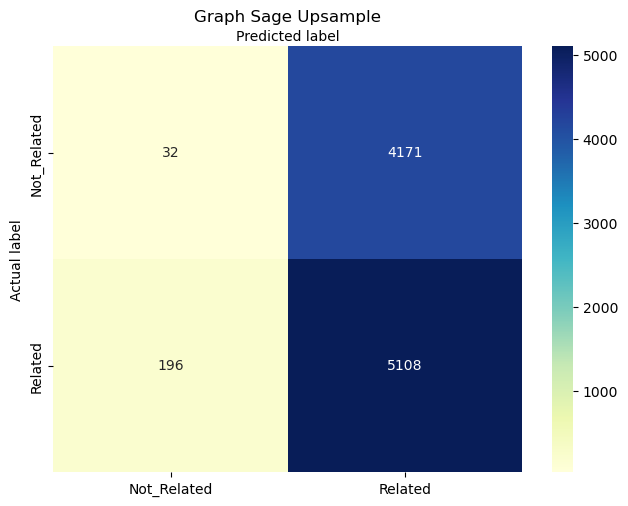

In [25]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
cnf_matrix_n[0][0]

32

In [27]:
import sklearn

In [28]:
print(sklearn.metrics.classification_report(clabels[cidx_test], cout[cidx_test], target_names=class_names))

              precision    recall  f1-score   support

 Not_Related       0.14      0.01      0.01      4203
     Related       0.55      0.96      0.70      5304

    accuracy                           0.54      9507
   macro avg       0.35      0.49      0.36      9507
weighted avg       0.37      0.54      0.40      9507



In [29]:
cnf_matrix_n

array([[  32, 4171],
       [ 196, 5108]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

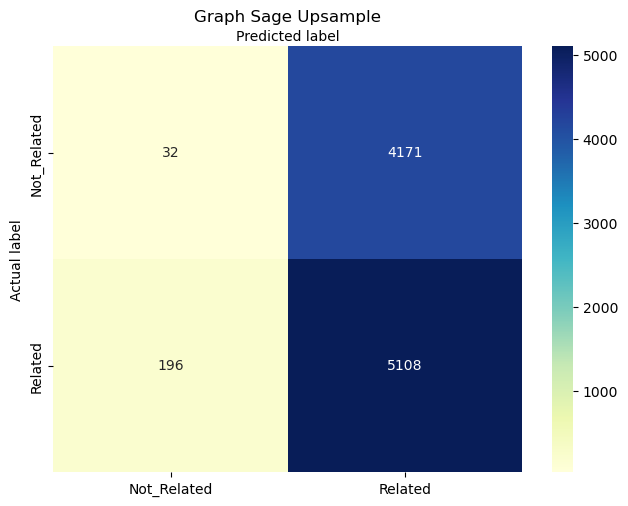

In [30]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n_valid = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
false_positive_test=cnf_matrix_n[0][1]
true_positive_test=cnf_matrix_n[1][1]
true_negative_test=cnf_matrix_n[0][0]
false_negative_test=cnf_matrix_n[1][0]

false_positive_valid=cnf_matrix_n_valid[0][1]
true_positive_valid=cnf_matrix_n_valid[1][1]
true_negative_valid=cnf_matrix_n_valid[0][0]
false_negative_valid=cnf_matrix_n_valid[1][0]

In [32]:
def specificity(true_negative,false_positive):
    return str(true_negative/(true_negative+false_positive))
def sensitivity(true_positive,false_negative):
    return str(true_positive/(true_positive+false_negative))

In [33]:
print('test')
print("Specificity: "+ specificity(true_negative_test,false_positive_test))
print("Sensitivity: "+ sensitivity(true_positive_test,false_negative_test))


test
Specificity: 0.0076136093266714255
Sensitivity: 0.9630467571644042


In [34]:
print('validation')
print("Specificity: "+ specificity(true_negative_valid,false_positive_valid))
print("Sensitivity: "+sensitivity(true_positive_valid,false_negative_valid))


validation
Specificity: 0.009166666666666667
Sensitivity: 0.9775


In [35]:
test_labels=clabels[cidx_test]
test_output=cout[cidx_test]
valid_labels=clabels[cidx_valid]
valid_output=cout[cidx_valid]

In [36]:
test_labels_enc=np.eye(4)[test_labels]
test_output_enc=np.eye(4)[test_output]
valid_labels_enc=np.eye(4)[valid_labels]
valid_output_enc=np.eye(4)[valid_output]

In [37]:
roc_auc_score(clabels[cidx_test], cout[cidx_test])

0.48533018324553784

In [38]:
roc_auc_score(clabels[cidx_valid], cout[cidx_valid])

0.49333333333333335

In [39]:
c_out=output.cpu().detach()

In [40]:
test_output=c_out[cidx_test]

In [41]:
dummy_labels=pd.get_dummies(clabels[cidx_test]).values
dummy_preds=pd.get_dummies(cout[cidx_test]).values

In [42]:
from sklearn import metrics
fpr=[]
tpr=[]
roc_auc=[]
import matplotlib.pyplot as plt
for i in range(1,2):
        fpr_, tpr_, _ = metrics.roc_curve(dummy_labels[:, i], test_output[:, i])
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(roc_auc_score(dummy_labels[:, i], test_output[:, i]))

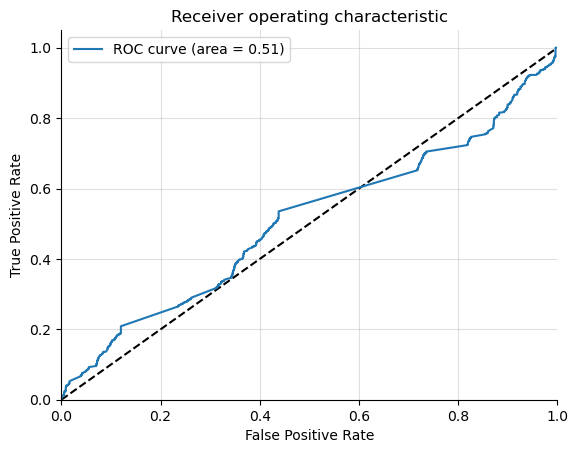

In [43]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
labels=['Genes Not Associated to ASD',"Genes Associated to ASD"]
for i in range(1):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % (roc_auc[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()